# Current Incubator History Visualizations

This notebook provides visualizations of Incubator edit data trends, for Incubator projects that have not yet graduated.

* **Basic stats:** counts, etc.
* **Part 1: Visualizing project size** (i.e. how many pages do the current Incubator projects have?)
* **Part 2: Visualizing first and last edits** (i.e., how long have current Incubator projects been in the Incubator?)
* **Part 3: Visualizing project size x start date** (i.e., looking at projects' number of pages x how long they've been in the Incubator)
* **Part 4: Visualizing monthly edits** (i.e., for each project currently in the Incubator, how many edits were made each month?)

In [74]:
library(tidyverse)
library(plyr)
library(here)
library(matrixStats)
library(kableExtra)
library(pollster)
library(ggrepel)
library(jsonlite)
library(reticulate)
here()

[1] "/srv/home/cmyrick/incubator-data-exploration"

# Load data

In [75]:
## Run all cells of notebook
#pycmd <- "python -m jupyter nbconvert --ExecutePreprocessor.timeout=None --to notebook --execute 02_wrangling_scripts/wrangle_final.ipynb"
#cat(pycmd)

## Execute command to run another notebook (in this case wrangle_final.ipynb)
## This will update the TSV outputs from that notebook, which will be loaded into this notebook in the cells below
#system(pycmd, intern = TRUE) #### update with names

In [76]:
#prep to be able to run spark queries using reticulate package
#per https://wikitech.wikimedia.org/wiki/Data_Engineering/Systems/Conda#wmfdata-python_through_reticulate
conda_env_data <- paste(
    system2(
        "conda",
        args = c("info", "-a", "--json"),
        stdout = TRUE),
    collapse = '') |>
    fromJSON()
use_condaenv(conda_env_data[['active_prefix']])
wmfdata <- import('wmfdata')


In [77]:
# Query page counts data
sql_text <- readLines(here("02_wrangling_scripts/queries/page_count_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
dfp_import <- wmfdata$spark$run(sql_string)

In [78]:
# Query first/last/percentile edits data
sql_text <- readLines(here("02_wrangling_scripts/queries/edit_percentiles_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
df_import <- wmfdata$spark$run(sql_string)

In [79]:
# Query monthly edits data
sql_text <- readLines(here("02_wrangling_scripts/queries/monthly_edits_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
dfe_import <- wmfdata$spark$run(sql_string)

In [80]:
# Join each df with language names and statuses, and FILTER OUT GRADS 
projs <- read_tsv(here("03_wrangled_data/projects.tsv"), show_col_types=F) %>%
 select(prefix, language_name, canonical_status, `test-host`, project)
df <- df_import %>% left_join(., projs, by="prefix") %>% filter(grepl("test", `test-host`))
dfp <- dfp_import %>% left_join(., projs, by="prefix") %>% filter(grepl("test", `test-host`))
dfe <- dfe_import %>% left_join(., projs, by="prefix") %>% filter(grepl("test", `test-host`))

# Basic stats

**Number of test wikis in Incubator**

In [81]:
xtabs(~project, (projs %>% filter(!grepl("source|versity", project)) %>% filter(grepl("test", `test-host`))))

project
 Wikibooks   Wikinews  Wikipedia  Wikiquote Wikivoyage Wiktionary 
       134        121        751        111        131        293 

**Number of langauages with test wiki(s) in Incubator**

In [82]:
nrow(projs %>% filter(grepl("test", `test-host`)) %>% select(language_name) %>% distinct(.))

[1] 1067

# Part 1: Visualizing project size

In [83]:
# Define project type
dfp$project_type <- NA
dfp$project_type[grepl("Wp/", dfp$prefix)] <- "Wikipedia"
dfp$project_type[grepl("Wb/", dfp$prefix)] <- "Wikibooks"
dfp$project_type[grepl("Wn/", dfp$prefix)] <- "Wikinews"
dfp$project_type[grepl("Wq/", dfp$prefix)] <- "Wikiquote"
dfp$project_type[grepl("Wt/", dfp$prefix)] <- "Wiktionary"
dfp$project_type[grepl("Wv/", dfp$prefix)] <- "Wikiversity"
dfp$project_type[grepl("Wy/", dfp$prefix)] <- "Wikivoyage"

In [84]:
head(dfp)

snapshot prefix page_namespace pages_count language_name    canonical_status
1 2024-07  Wt/ltg   0             27         Latgalian        NA              
2 2024-07  Wp/rgn   0            105         Romagnol         NA              
3 2024-07  Wp/dar 828             39         Dargwa           NA              
4 2024-07  Wt/shi   0            449         Tachelhit        NA              
5 2024-07  Wp/kkv   0             16         Kangean          NA              
6 2024-07  Wq/lzh   0             12         Literary Chinese NA              
  test-host project    project_type
1 test      Wiktionary Wiktionary  
2 test      Wikipedia  Wikipedia   
3 test      Wikipedia  Wikipedia   
4 test      Wiktionary Wiktionary  
5 test      Wikipedia  Wikipedia   
6 test      Wikiquote  Wikiquote

In [85]:
# Table: Median and mean project size (pages) by project type
dfp %>% 
 dplyr::group_by(project_type) %>% 
 dplyr::summarise(mean=round(mean(pages_count),0)) %>% dplyr::ungroup() %>%
 left_join(., (dfp %>% dplyr::group_by(project_type) %>% dplyr::summarise(median=median(pages_count)) %>% dplyr::ungroup()), by="project_type") %>%
 dplyr::rename("mean pages" = "mean", "median pages" = "median") %>% select(1,3,2)

project_type median pages mean pages
1 Wikibooks    2             18       
2 Wikinews     4             57       
3 Wikipedia    3             60       
4 Wikiquote    3             37       
5 Wikivoyage   3             32       
6 Wiktionary   5            144

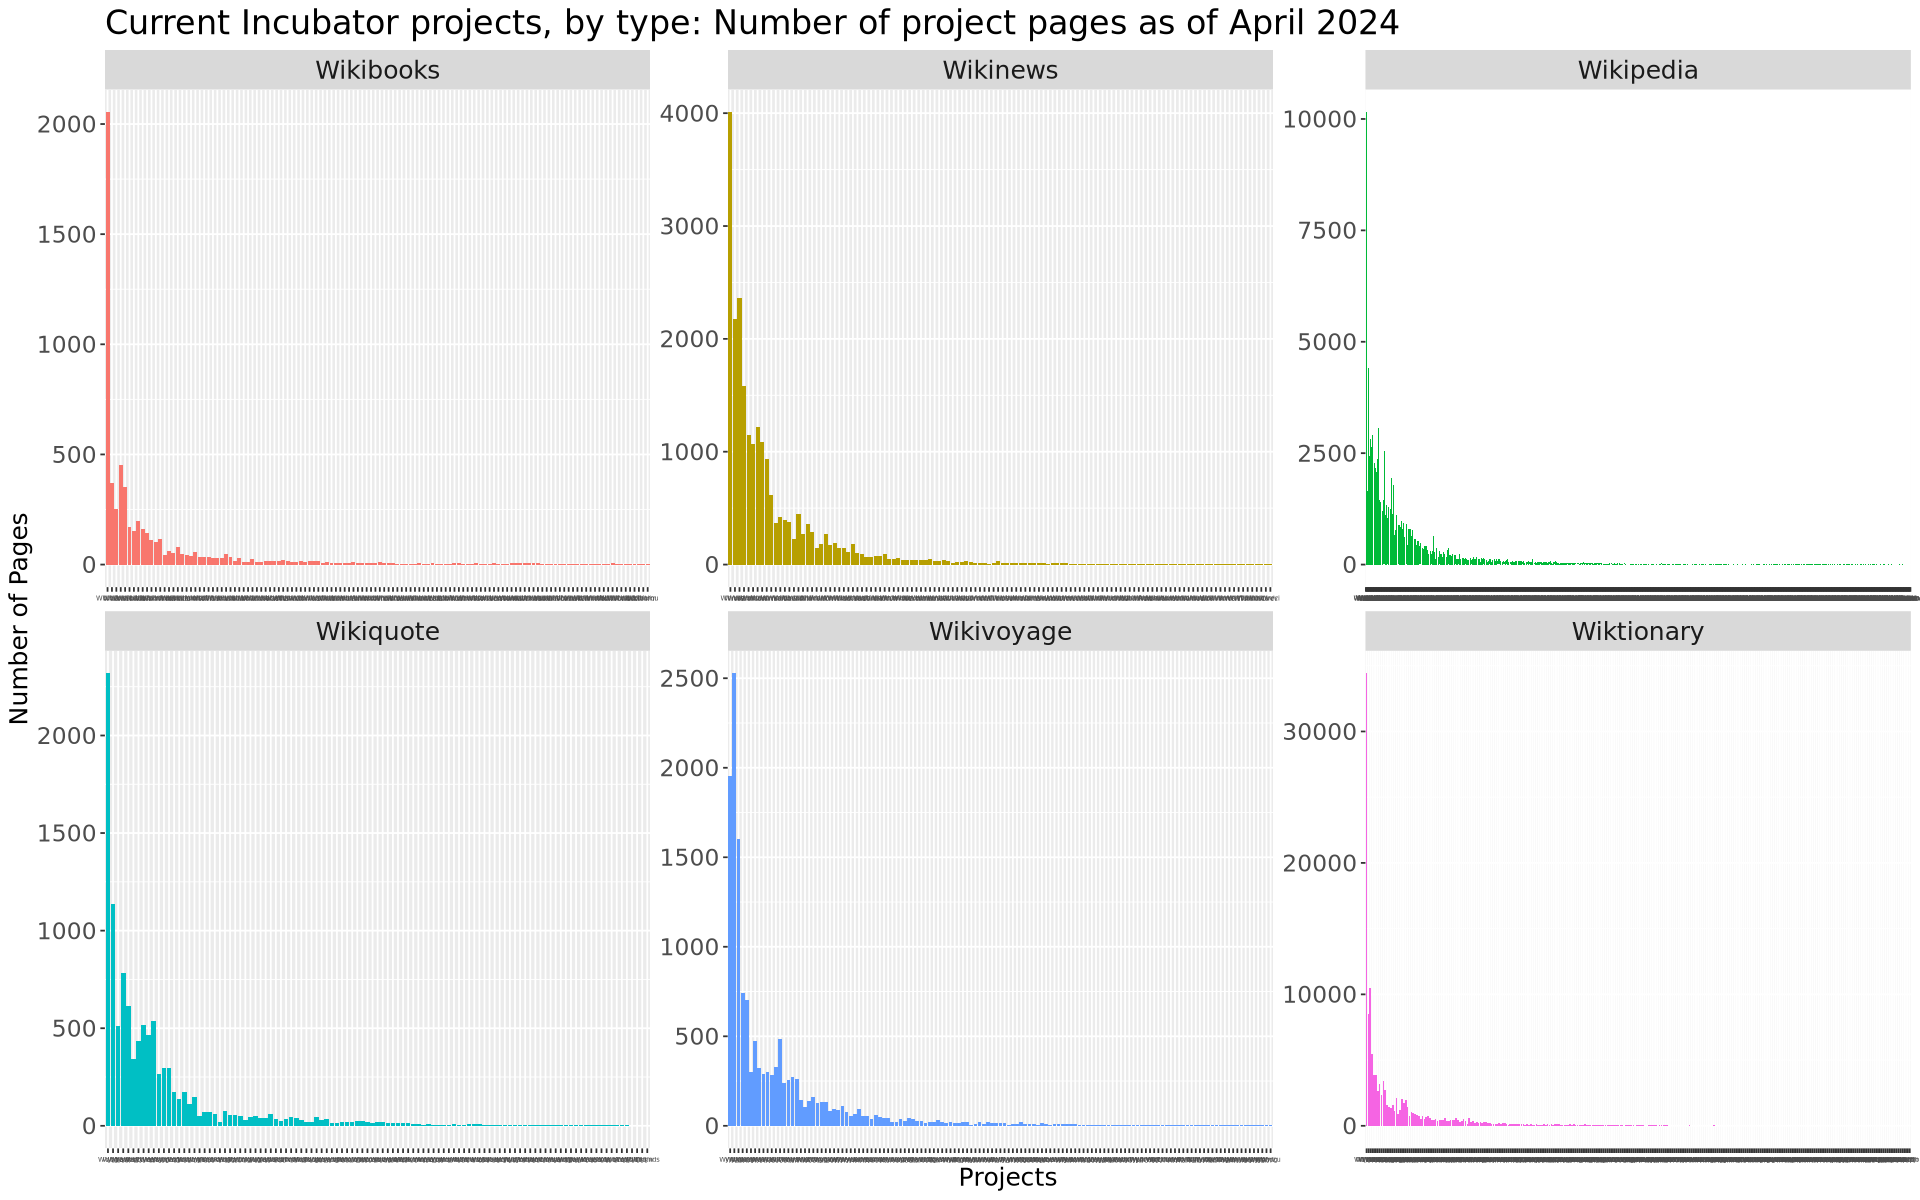

In [86]:
options(repr.plot.width=16, repr.plot.height=10)
dfp %>%
 ggplot(aes(x=reorder(prefix,-pages_count), y=pages_count, fill=project_type)) +
 geom_bar(stat="identity") +
 facet_wrap(.~project_type, ncol=3, scales="free") +
 theme(plot.title=element_text(size=20), 
       axis.text.y=element_text(size=14),
       axis.text.x=element_text(size=04),
       axis.title=element_text(size=15),
       strip.text=element_text(size=15),
       legend.position="none") +
 labs(title="Current Incubator projects, by type: Number of project pages as of April 2024") +
 xlab("Projects") +
 ylab("Number of Pages")

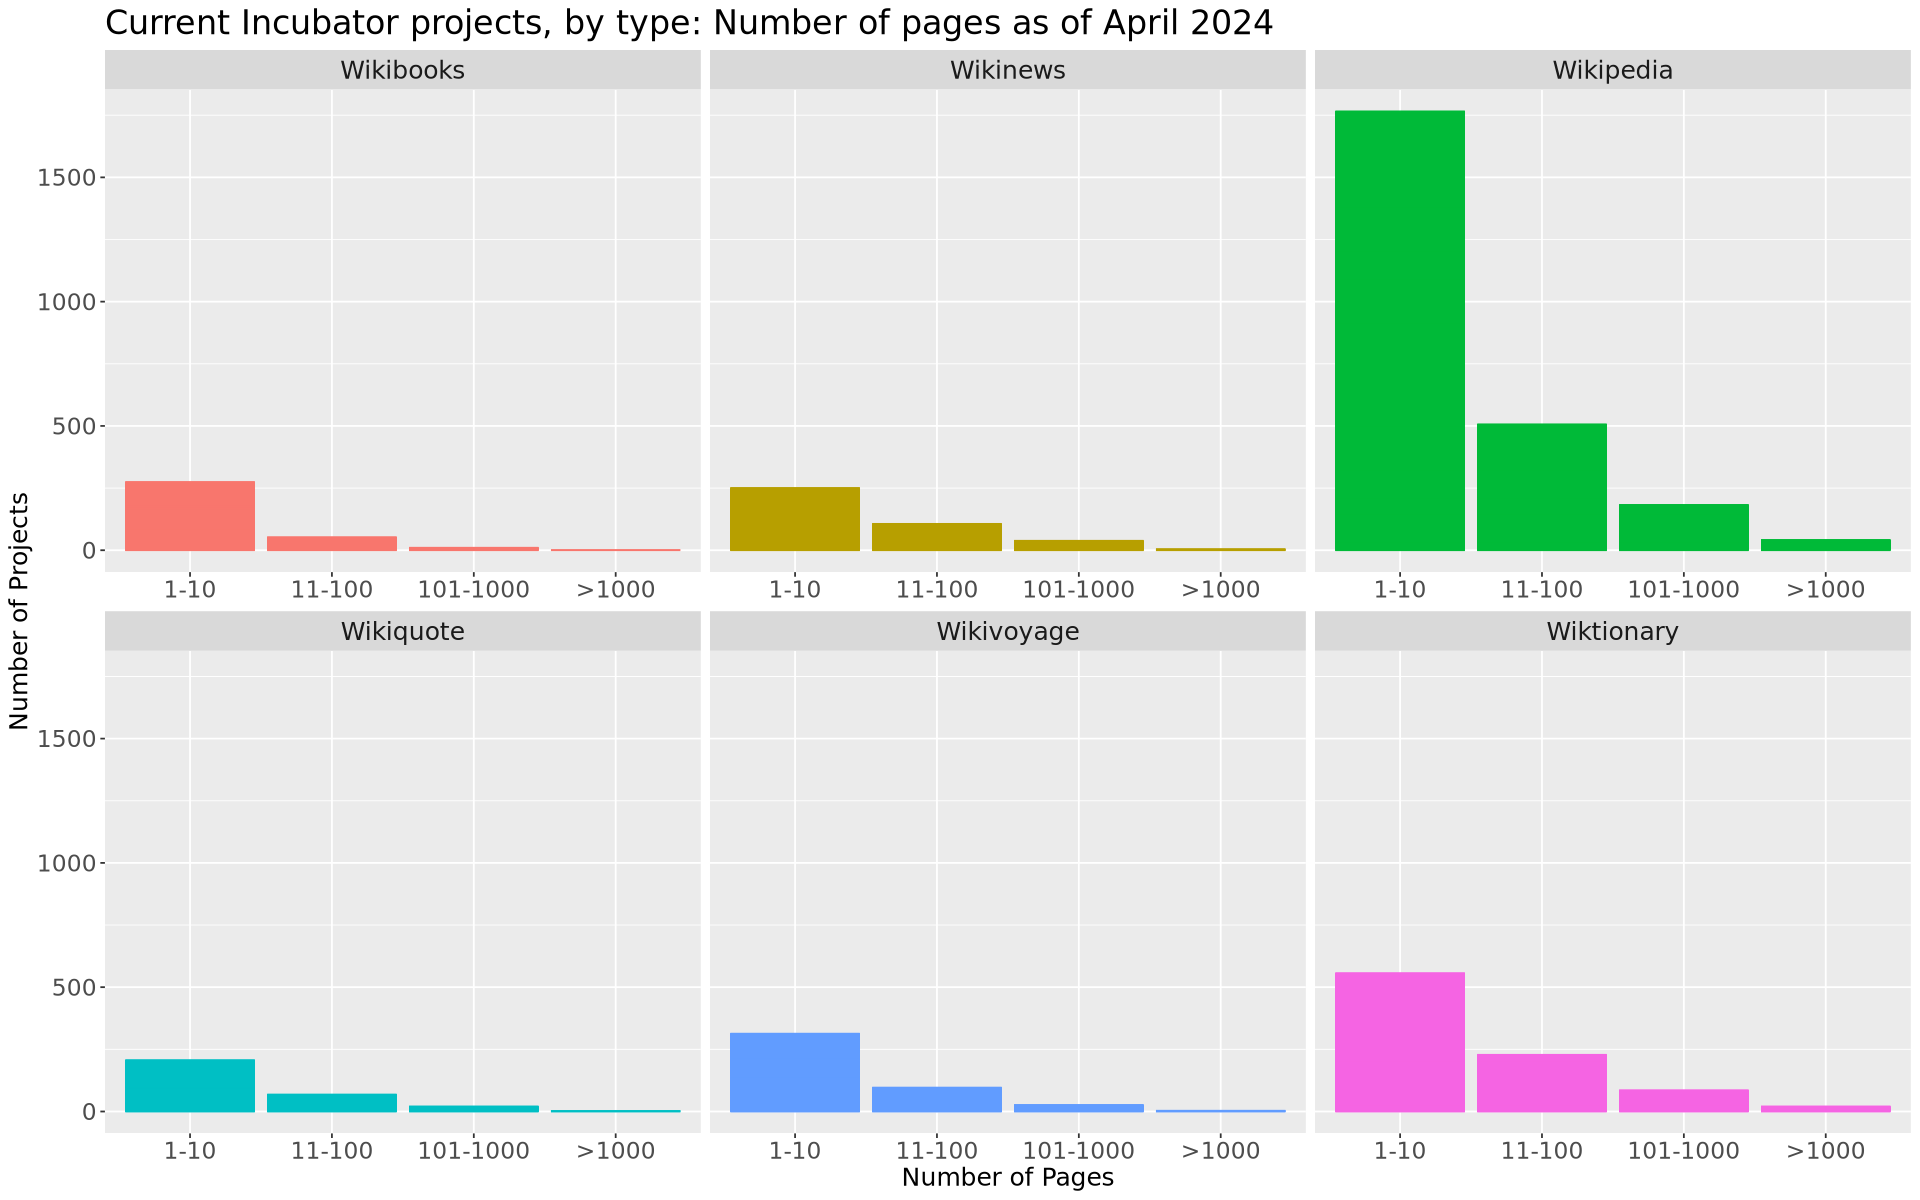

In [87]:
# BUCKETS
dfp$bucket <- NA
dfp$bucket[dfp$pages_count>=1 & dfp$pages_count==0] <- "0"
dfp$bucket[dfp$pages_count>=1 & dfp$pages_count<11] <- "1-10"
dfp$bucket[dfp$pages_count>10 & dfp$pages_count<101] <- "11-100"
dfp$bucket[dfp$pages_count>100 & dfp$pages_count<1001] <- "101-1000"
dfp$bucket[dfp$pages_count>1000] <- ">1000"
dfp$bucket <-  factor(dfp$bucket, levels = c("0", "1-10", "11-100", "101-1000", ">1000"))

#dummy pages_count
dfp$dummy_pages_count <- 1

#plot
dfp %>%
 ggplot(aes(x=reorder(bucket,-dummy_pages_count), y=dummy_pages_count, color=project_type)) +
 geom_bar(stat="identity") + xlab("Number of Pages") +
 theme(plot.title=element_text(size=20), 
       axis.text=element_text(size=14),
       axis.title=element_text(size=15),
       strip.text=element_text(size=15),
       legend.position="none") +
 ylab("Number of Projects") +
 labs(title="Current Incubator projects, by type: Number of pages as of April 2024") +
 facet_wrap(.~project_type, ncol=3, scales="free_x")

In [88]:
# Show data plotted above as a table (i.e., page number buckets project, but as %s)
dfp$weight=1
as.data.frame(moe_crosstab(df=dfp, x=project_type, y=bucket, weight=weight)) %>%
 mutate(pct=paste0(round(pct,1), "%")) %>%
 select(project_type, bucket, pct) %>%
 spread(key=bucket, value=pct)

project_type 1-10  11-100 101-1000 >1000
1 Wikibooks    81.3% 15.4%  3%       0.3% 
2 Wikinews     62.8% 26.6%  9.5%     1%   
3 Wikipedia    70.8% 20.3%  7.3%     1.6% 
4 Wikiquote    69.6% 23%    6.8%     0.7% 
5 Wikivoyage   71.5% 21.9%  5.9%     0.7% 
6 Wiktionary   62.5% 25.6%  9.6%     2.2%

In [89]:
# Which projects have > 5,000 pages????
dfp %>% filter(pages_count > 5000)

snapshot prefix page_namespace pages_count language_name   canonical_status
1 2024-07  Wt/mad 0               5464       Madurese        NA              
2 2024-07  Wp/bgn 0               5403       Western Baluchi NA              
3 2024-07  Wt/wuu 0              34187       Wu              NA              
4 2024-07  Wt/mnc 0               8159       Manchu          NA              
5 2024-07  Wt/war 0              10353       Waray           NA              
  test-host project    project_type bucket dummy_pages_count weight
1 test      Wiktionary Wiktionary   >1000  1                 1     
2 test      Wikipedia  Wikipedia    >1000  1                 1     
3 test      Wiktionary Wiktionary   >1000  1                 1     
4 test      Wiktionary Wiktionary   >1000  1                 1     
5 test      Wiktionary Wiktionary   >1000  1                 1

In [90]:
# How many projects have between 1 and 5 pages????
nrow(dfp %>% filter(pages_count < 6))

[1] 2919

# Part 2: Visualizing first and last edits

## How long have current Incubator projects been in the Incubator?

In [91]:
# Define project type
df$project_type <- NA
df$project_type[grepl("Wp/", df$prefix)] <- "Wikipedia"
df$project_type[grepl("Wb/", df$prefix)] <- "Wikibooks"
df$project_type[grepl("Wn/", df$prefix)] <- "Wikinews"
df$project_type[grepl("Wq/", df$prefix)] <- "Wikiquote"
df$project_type[grepl("Wt/", df$prefix)] <- "Wiktionary"
df$project_type[grepl("Wv/", df$prefix)] <- "Wikiversity"
df$project_type[grepl("Wy/", df$prefix)] <- "Wikivoyage"

In [92]:
# Define total days in Incubator
df <- df %>% 
 mutate(total_days_in_incubator = Sys.Date() - as.Date(first_edit_timestamp)) %>%
 mutate(total_days_in_incubator = as.numeric(gsub(" days", "", total_days_in_incubator))) %>%
 mutate(total_days_since_last_edit = Sys.Date() - as.Date(last_edit_timestamp)) %>%
 mutate(total_days_since_last_edit = as.numeric(gsub(" days", "", total_days_since_last_edit)))
head(df)

prefix total_edits first_edit_timestamp last_edit_timestamp
1 Wb/rjs   3         2023-12-22           2024-02-25         
2 Wn/ie    5         2020-08-14           2022-09-30         
3 Wp/hnd  46         2010-08-05           2022-02-26         
4 Wp/kvr  79         2010-12-04           2024-03-23         
5 Wp/mrw  10         2008-05-17           2023-02-25         
6 Wt/gld 266         2020-07-14           2023-03-29         
  avg_first_edit_5pct avg_last_edit_5pct language_name   canonical_status
1 2023-12-22          2024-02-25         Rajbanshi       NA              
2 2020-08-14          2022-09-30         Interlingue     NA              
3 2010-08-05          2020-11-29         Southern Hindko NA              
4 2010-12-20          2022-10-13         Kerinci         NA              
5 2008-05-17          2023-02-25         Maranao         NA              
6 2020-10-23          2021-07-29         Nanai           NA              
  test-host project    project_type total_days_in_incubator
1 test      Wikibooks  Wikibooks     228                   
2 test      Wikinews   Wikinews     1453                   
3 test      Wikipedia  Wikipedia    5115                   
4 test      Wikipedia  Wikipedia    4994                   
5 test      Wikipedia  Wikipedia    5925                   
6 test      Wiktionary Wiktionary   1484                   
  total_days_since_last_edit
1 163                       
2 676                       
3 892                       
4 136                       
5 528                       
6 496

In [93]:
# Min and max of all current Incubator projects
print(min(df$total_days_in_incubator))
print(max(df$total_days_in_incubator))

[1] 12
[1] 7908


In [113]:
# Range of all current Incubator projects
options(repr.plot.width=16, repr.plot.height=10)
df %>%
 filter(`test-host` == "test") %>% # exclude closed, because of difference in what start date means
 ggplot(aes(x=reorder(prefix,-total_days_in_incubator), y=total_days_in_incubator)) +
 geom_bar(stat="identity") + xlab("Projects") +
 theme(plot.title=element_text(size=20), 
       axis.text.y=element_text(size=14),
       axis.text.x=element_text(size=04),
       axis.title=element_text(size=15),
       legend.position="none") +
 ylab("Days in Incubator") +
 labs(title="Current Incubator projects: Number of days in Incubator")

In [115]:
# Range of all current Incubator projects, by project type
df %>%
 filter(`test-host` == "test") %>% # exclude closed, because of difference in what start date means
 filter(total_days_in_incubator < 6641) %>% # exclude > days ago June 2006
 ggplot(aes(x=reorder(prefix,-total_days_in_incubator), y=total_days_in_incubator, fill=project_type)) +
 geom_bar(stat="identity") +
 ylab("Days in Incubator") + xlab("Projects") +
 labs(title="Current Incubator projects: Number of days in Incubator") +
 facet_grid(.~project_type, scales="free_x") + 
 theme(plot.title=element_text(size=20), 
       axis.text.y=element_text(size=14),
       axis.text.x=element_text(size=04),
       axis.title=element_text(size=15),
       strip.text=element_text(size=15),
       legend.position="none") 

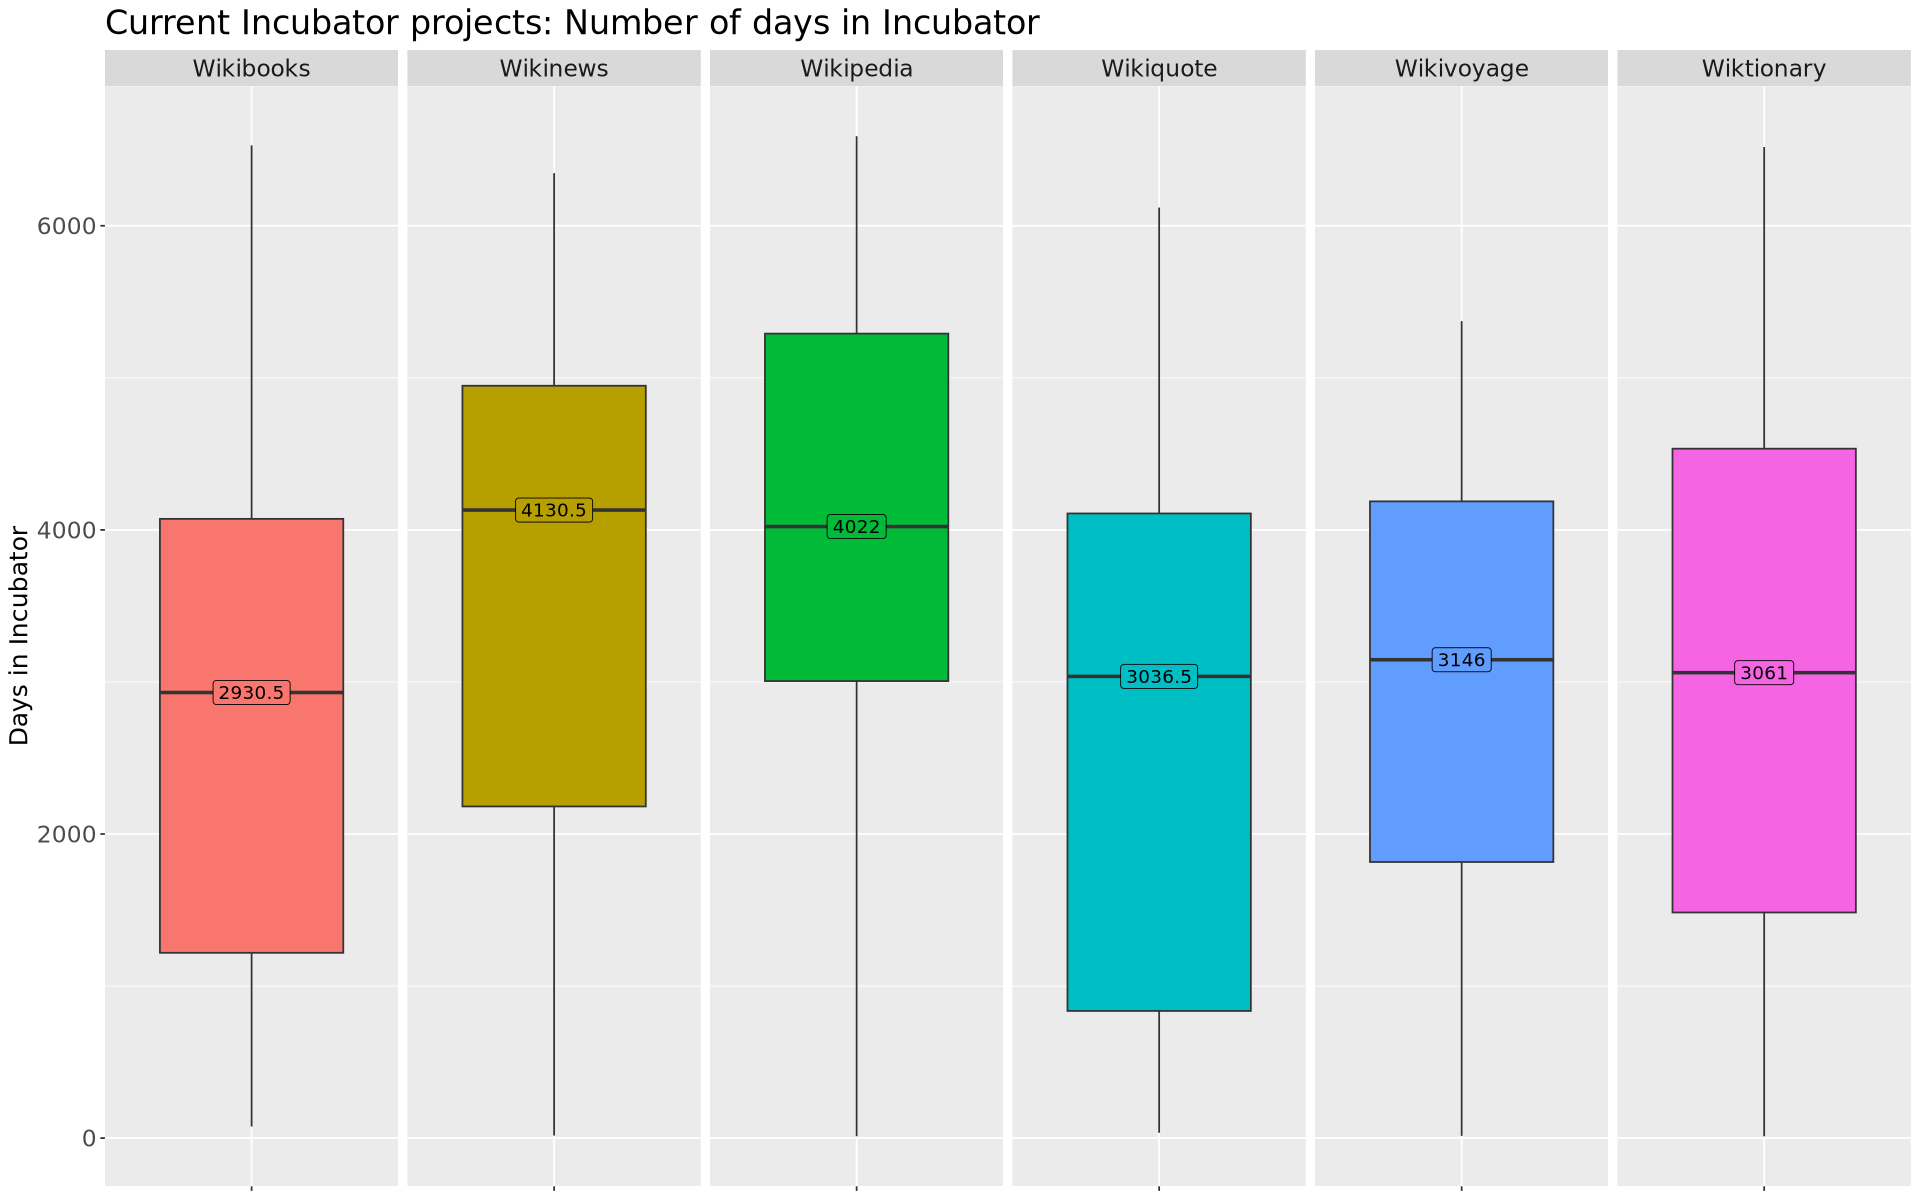

In [116]:
# Boxplots of all current Incubator projects, by project type

# first summary stats
summ <- df %>% 
 filter(`test-host` == "test") %>% # exclude closed, because of difference in what start date means
 filter(total_days_in_incubator < 6641) %>% # exclude > days ago June 2006
  dplyr::group_by(project_type) %>% 
  dplyr::summarize(mean = mean(total_days_in_incubator), median = median(total_days_in_incubator), sd = sd(total_days_in_incubator)) %>%
  dplyr::ungroup()

# now plot
df %>%
 filter(`test-host` == "test") %>% # exclude closed, because of difference in what start date means
 filter(total_days_in_incubator < 6641) %>% # exclude > days ago June 2006
 ggplot(aes(x = project_type, y = total_days_in_incubator, fill = project_type)) +
 geom_boxplot() +
 facet_grid(.~project_type, scales="free_x") + 
 geom_label(data = summ, aes(x = project_type, y = median, label = median)) +
 theme(legend.position="none", 
       strip.text=element_text(size=14), plot.title=element_text(size=20),
       axis.text.y=element_text(size=14), axis.title.y=element_text(size=15),
       axis.text.x = element_blank(), axis.title.x = element_blank()) +
 ylab("Days in Incubator") +
 labs(title="Current Incubator projects: Number of days in Incubator") 

In [122]:
# Dot plots of all current Incubator projects, by project type

options(repr.plot.width=16, repr.plot.height=08)

# First, add an "All" project type category
df_all <- df
df_all$project_type <- "All"
df_all <- rbind(df, df_all)

# Then, summary stats
summ <- df_all %>% 
 filter(`test-host` == "test") %>% # exclude closed, because of difference in what start date means
 filter(total_days_in_incubator < 6641) %>% # exclude > days ago June 2006
  dplyr::group_by(project_type) %>% 
  dplyr::summarize(mean = mean(total_days_in_incubator), median = median(total_days_in_incubator), sd = sd(total_days_in_incubator)) %>%
  dplyr::ungroup()

min(df_all$total_days_in_incubator[df_all$total_days_in_incubator < 6640])
max(df_all$total_days_in_incubator[df_all$total_days_in_incubator < 6640])

# Now plot
df_all %>%
 filter(`test-host` == "test") %>% # exclude closed, because of difference in what start date means
 filter(total_days_in_incubator < 6641) %>% # exclude > days ago June 2006
 filter(total_days_in_incubator < 6640) %>% # days starting June 2006
 ggplot(aes(x = project_type, y = total_days_in_incubator, color = project_type)) +
# geom_violin() +
 geom_point(position = position_jitter(seed = 1, width = 0.1)) +
 facet_grid(.~project_type, scales="free_x") + 
 geom_label_repel(  min.segment.length = 2,
      data = summ, aes(x = project_type, y = median, label = paste0("median: ", median), size=20)) +
 geom_label_repel( min.segment.length = 1,
     data = summ, aes(x = project_type, y = mean, label = paste0("mean: ", round(mean,1)), size=20)) + 
 theme(legend.position="none", strip.text=element_text(size=16), plot.title = element_text(size=20),
       plot.caption = element_text(size=12, color="dark gray"), axis.text.x = element_blank(), axis.title.x = element_blank(), 
       axis.title.y = element_text(size=15), axis.text.y = element_text(size=12, color="dark grey"),
      axis.ticks.x = element_blank()) +
 scale_y_continuous(name="Days in Incubator", breaks=seq(0,6600,365)) +
 scale_color_manual(values = c("dimgray", "#f8766dff", "#b79f00ff", "#00ba39ff", "#03bfc4ff", "#619cffff", "#f564e3ff")) +
 labs(title = "Current Incubator projects: Number of days in Incubator (with medians labeled)",
     caption = "July 2024")

[1] 12

[1] 6589

In [123]:
## How many projects have been in the Incubator for more than 4 years (1460 days)?

nrow(df %>% 
     filter(total_days_in_incubator>1460) %>% 
     arrange(desc(total_days_in_incubator))%>%
     select(prefix) %>%
     unique(.))

[1] 1264

In [124]:
## Which projects have been in the Inubator for more than 4 years (1460 days)?
## remove "head()" for full list

head(df %>% filter(total_days_in_incubator>1460) %>% 
     select(prefix, language_name, first_edit_timestamp, avg_first_edit_5pct, total_days_in_incubator) %>%
     arrange(desc(total_days_in_incubator)) )

prefix language_name          first_edit_timestamp avg_first_edit_5pct
1 Wt/sco Scots                  2002-12-12           2004-08-13         
2 Wp/vmf East Franconian German 2003-08-06           2005-07-31         
3 Wp/na  Nauru                  2003-08-09           2005-02-09         
4 Wt/ch  Chamorro               2004-07-22           2005-12-15         
5 Wb/zu  Zulu                   2004-07-31           2006-06-22         
6 Wb/sw  Swahili                2004-08-07           2004-10-20         
  total_days_in_incubator
1 7908                   
2 7671                   
3 7668                   
4 7320                   
5 7311                   
6 7304

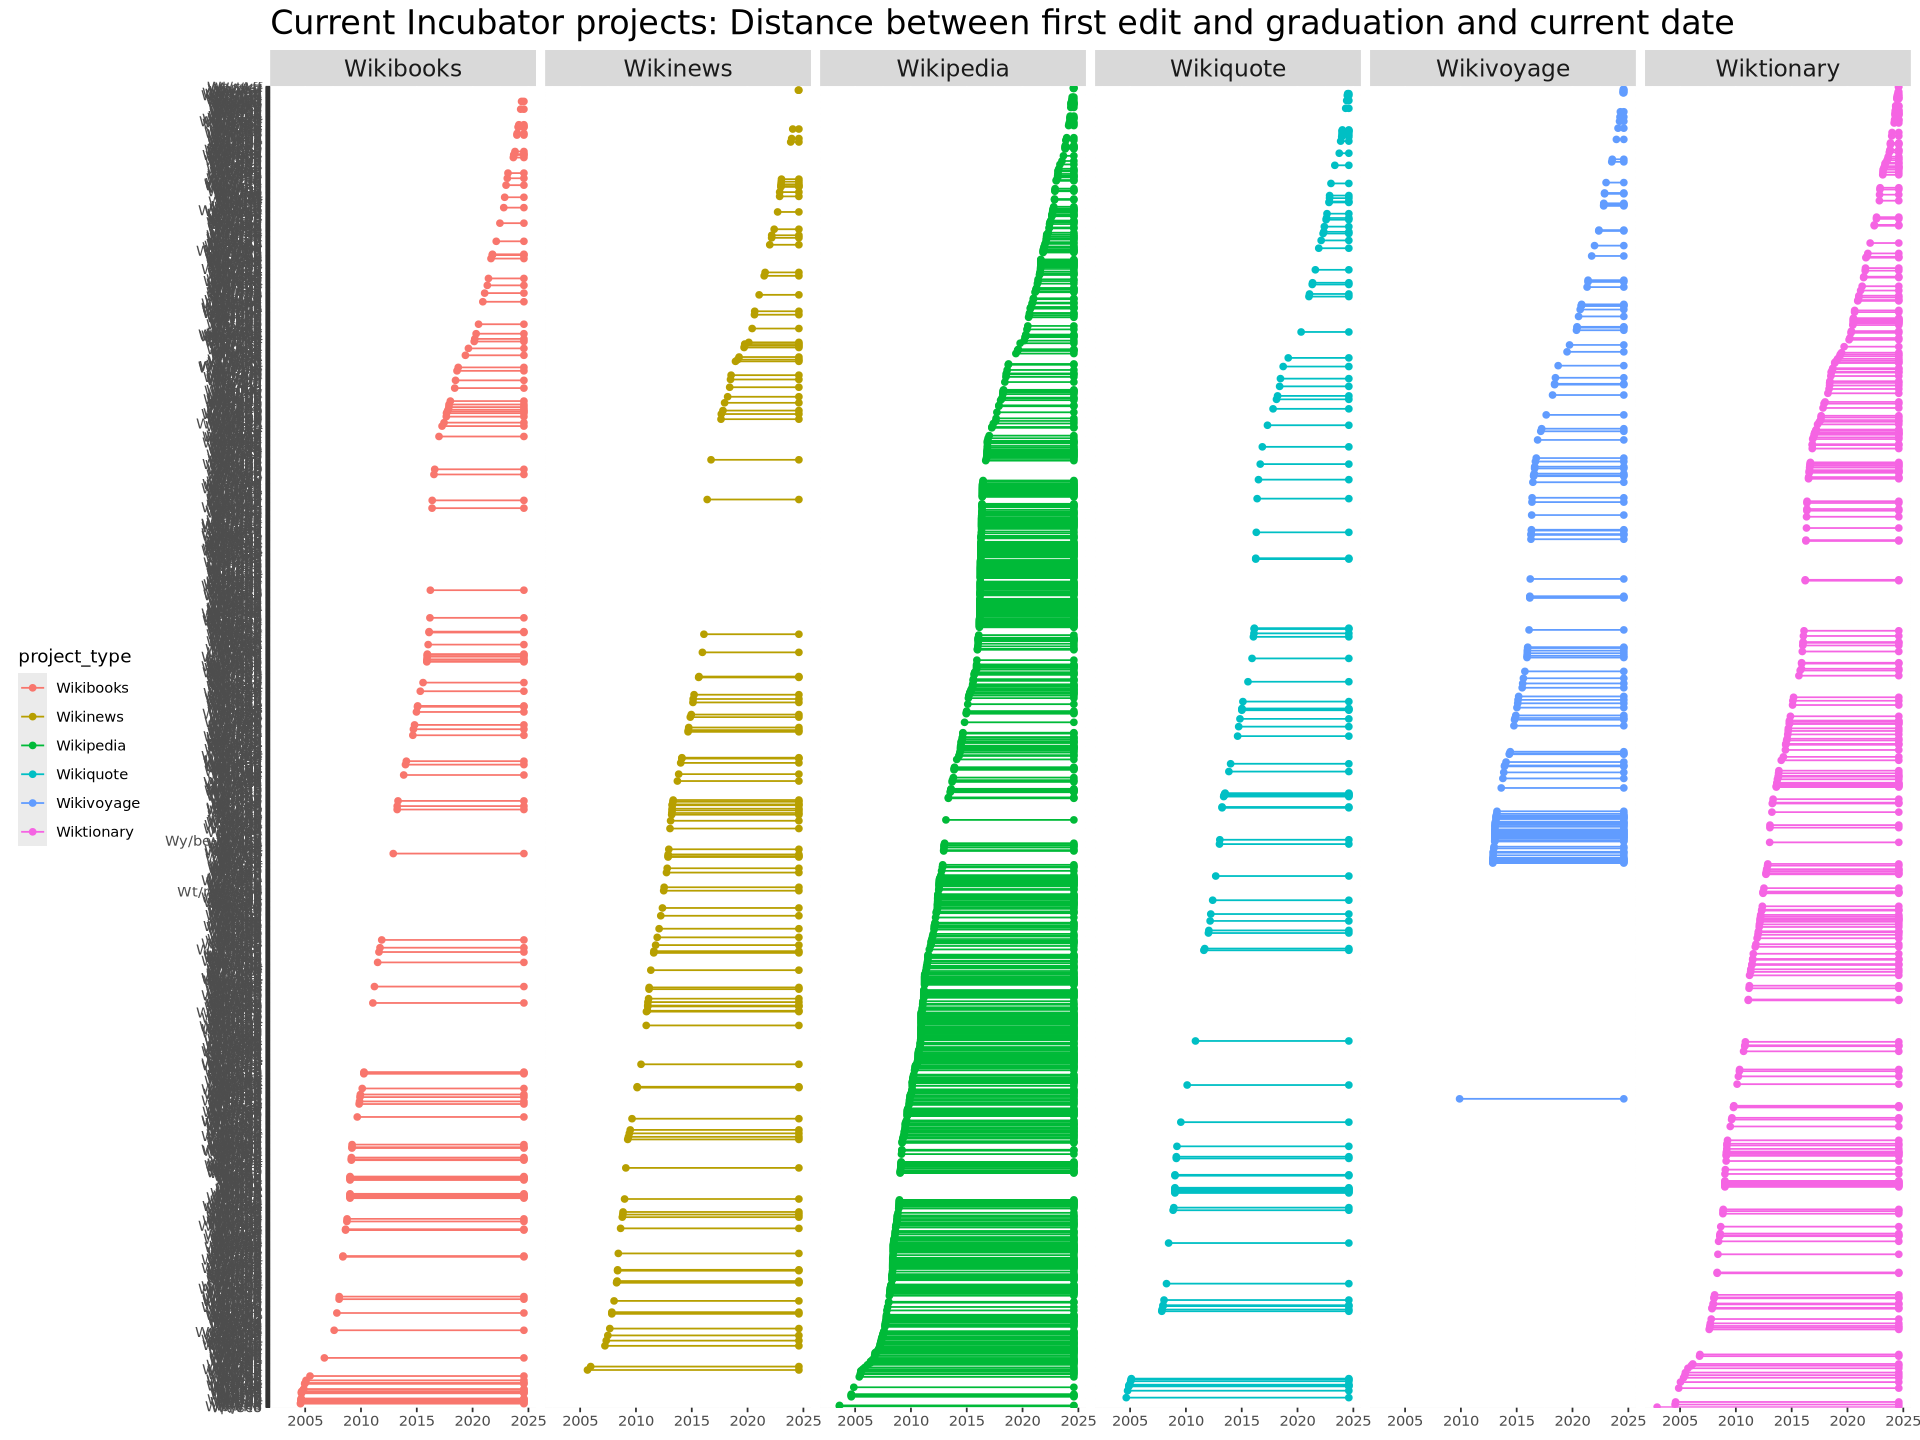

In [125]:
# Plot time in incubator
options(repr.plot.width=16, repr.plot.height=12)

## PREP

first_edit <- df %>% 
  select(prefix, language_name, first_edit_timestamp, project_type, total_days_since_last_edit) %>%
  mutate(first_edit_timestamp = as.Date(first_edit_timestamp)) %>%
  mutate(type= "1- First edit") %>%
  dplyr::rename(edit = first_edit_timestamp)          
current <- df %>% 
  mutate(current_dt = as.Date(Sys.Date())) %>%
  select(prefix, language_name, current_dt, project_type, total_days_since_last_edit) %>%
  mutate(type= "3- Current date") %>%
  dplyr::rename(edit = current_dt)

first_to_current <- rbind(first_edit, current) ## bind

first_to_current <- df %>%
  select(prefix, first_edit_timestamp) %>%
  right_join(., first_to_current, by = "prefix") ## re-add first_edit_timestamp column for ordering in plot


## PLOT
first_to_current %>%
  ggplot(aes(x=reorder(prefix,edit), y=edit, color=project_type)) +
  geom_line() +
  geom_point() +
  coord_flip() +
  facet_grid(.~project_type) +
  theme(legend.position = "left",  strip.text=element_text(size=14), axis.title = element_blank(),
       plot.title = element_text(size=20)) +
 labs(title = "Current Incubator projects: Distance between first edit and graduation and current date")


In [126]:
head(df)

prefix total_edits first_edit_timestamp last_edit_timestamp
1 Wb/rjs   3         2023-12-22           2024-02-25         
2 Wn/ie    5         2020-08-14           2022-09-30         
3 Wp/hnd  46         2010-08-05           2022-02-26         
4 Wp/kvr  79         2010-12-04           2024-03-23         
5 Wp/mrw  10         2008-05-17           2023-02-25         
6 Wt/gld 266         2020-07-14           2023-03-29         
  avg_first_edit_5pct avg_last_edit_5pct language_name   canonical_status
1 2023-12-22          2024-02-25         Rajbanshi       NA              
2 2020-08-14          2022-09-30         Interlingue     NA              
3 2010-08-05          2020-11-29         Southern Hindko NA              
4 2010-12-20          2022-10-13         Kerinci         NA              
5 2008-05-17          2023-02-25         Maranao         NA              
6 2020-10-23          2021-07-29         Nanai           NA              
  test-host project    project_type total_days_in_incubator
1 test      Wikibooks  Wikibooks     228                   
2 test      Wikinews   Wikinews     1453                   
3 test      Wikipedia  Wikipedia    5115                   
4 test      Wikipedia  Wikipedia    4994                   
5 test      Wikipedia  Wikipedia    5925                   
6 test      Wiktionary Wiktionary   1484                   
  total_days_since_last_edit
1 163                       
2 676                       
3 892                       
4 136                       
5 528                       
6 496

# Part 3: Visualizing project size x start date

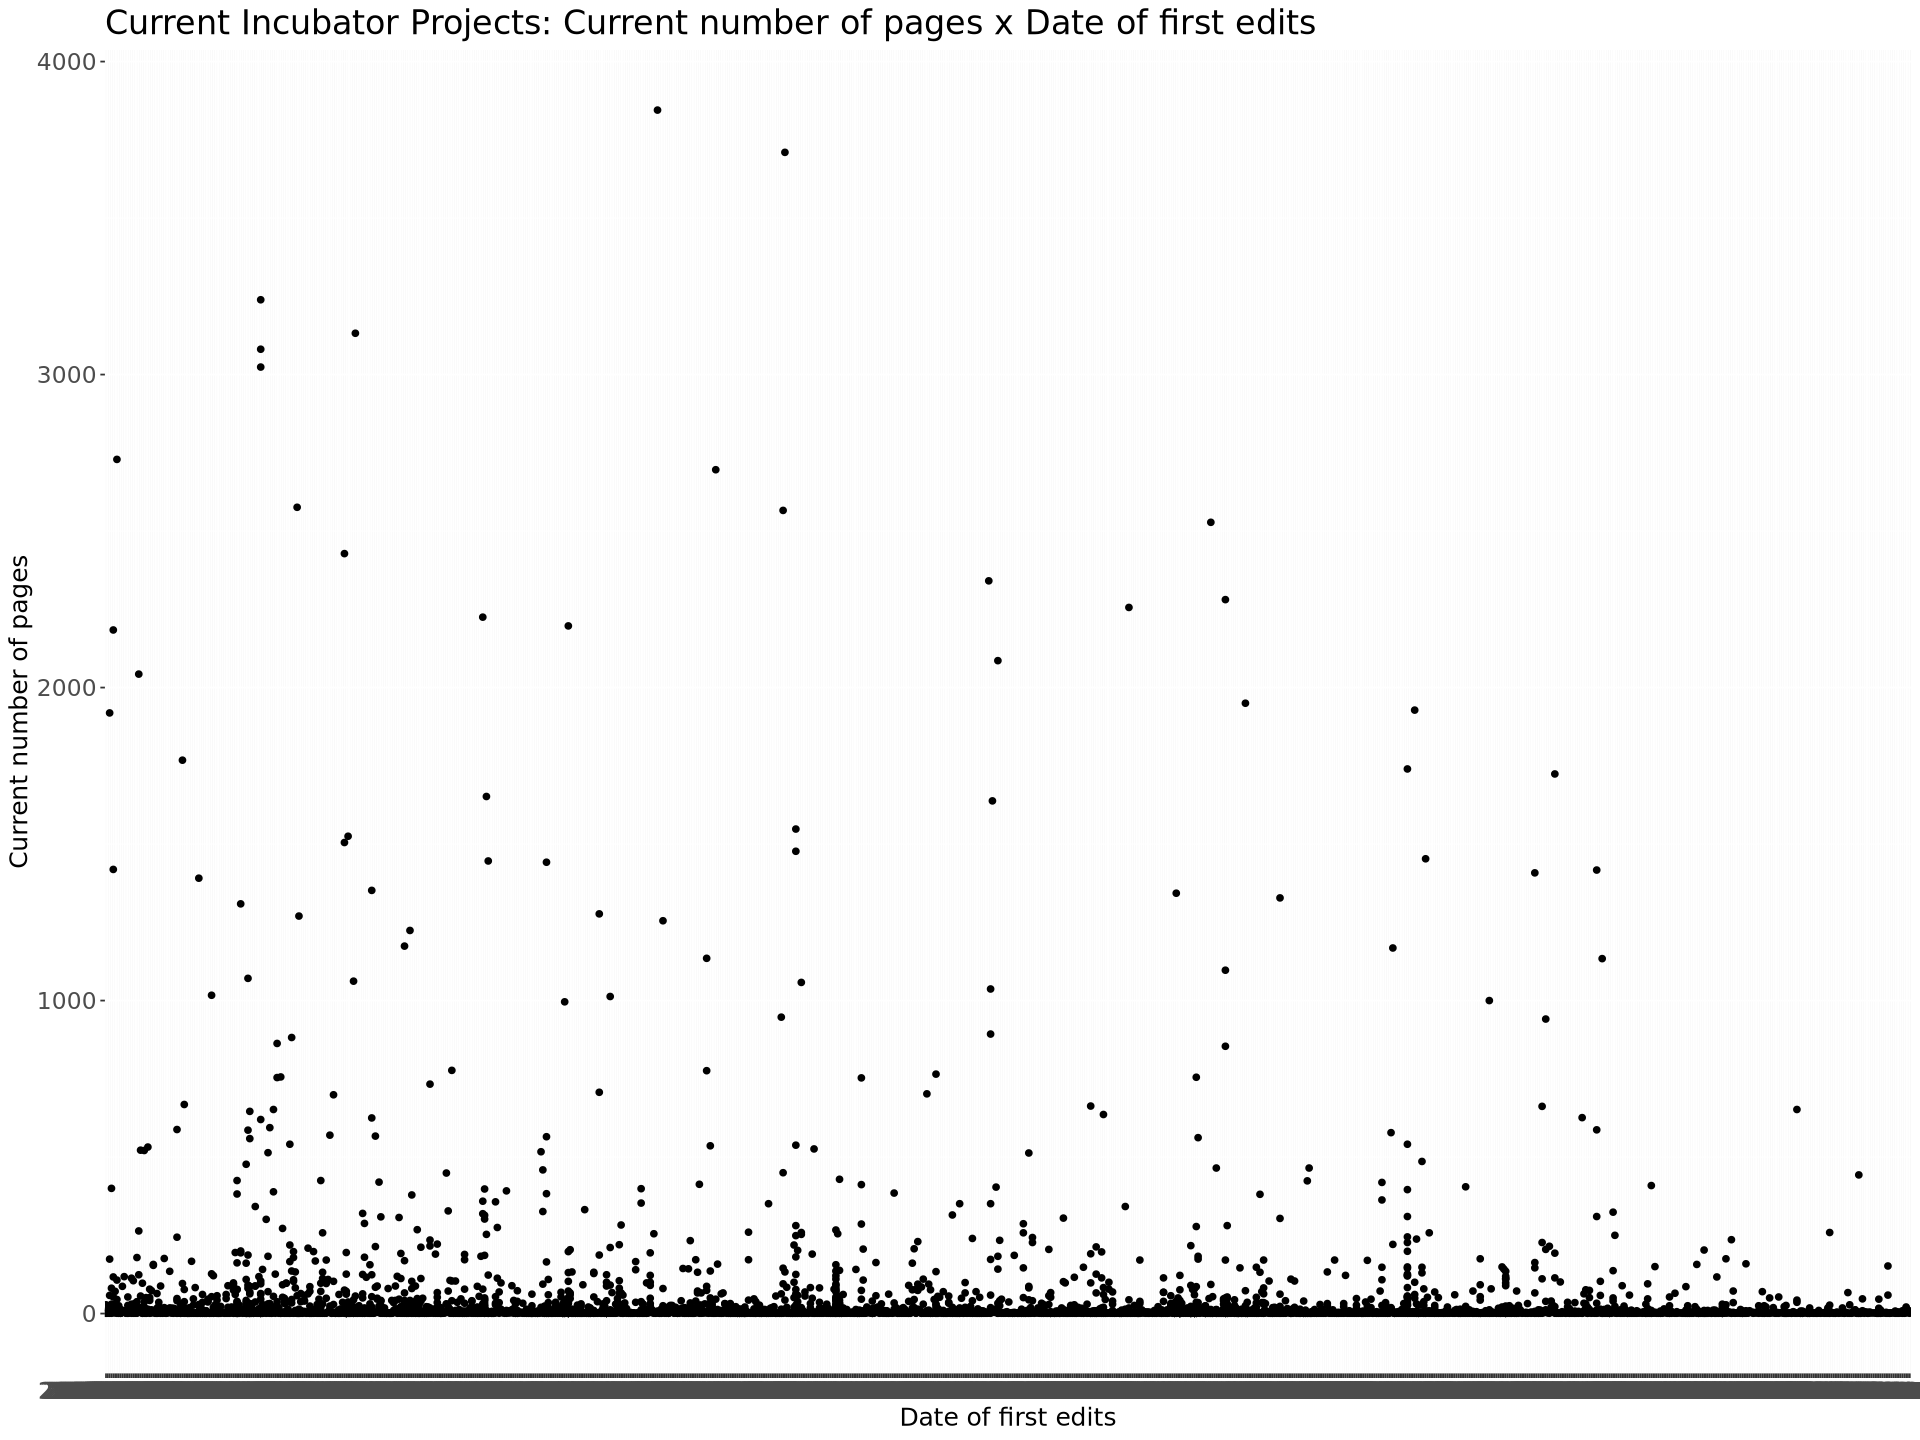

In [127]:
# Join page counts (dfp) with start dates (df)

df_combined <- df %>% 
    select(prefix, first_edit_timestamp, avg_first_edit_5pct) %>%
    full_join(., (dfp %>% select(prefix, pages_count) %>% dplyr::rename("page_count"="pages_count")), by="prefix" ) 

df_combined %>%
    filter(year(first_edit_timestamp) > 2006) %>% #filter out weird ones
    filter(page_count < 5000) %>% #filter out high page counts
    ggplot(aes(x=first_edit_timestamp, y=page_count)) +
    geom_point() +
     theme(legend.position = "left",  strip.text=element_text(size=14), axis.title = element_text(size=15), axis.text=element_text(size=14),
           plot.title = element_text(size=20)) +
    labs(title="Current Incubator Projects: Current number of pages x Date of first edits") +
    xlab("Date of first edits") +
    ylab("Current number of pages")

# Part 4: Visualizing monthly edits

In [128]:
# Define edit_dt
dfe <- dfe %>%
 mutate(edit_dt = paste(year, month, sep="-0")) %>%
 mutate(edit_dt = gsub("-010", "-10", edit_dt)) %>%
 mutate(edit_dt = gsub("-011", "-11", edit_dt)) %>%
 mutate(edit_dt = gsub("-012", "-12", edit_dt)) %>%
 mutate(edit_dt = paste(edit_dt, "-01", sep="")) %>% # add dummy day 01
 mutate(edit_dt = as.Date(edit_dt))

In [129]:
#QA
head(dfe %>% filter(prefix=="Wb/ace") %>% arrange(edit_dt))
head(dfe %>% filter(prefix=="Wb/blk") %>% arrange(edit_dt)) # should not have bc graduated

prefix year month page_namespace edits_count language_name canonical_status
1 Wb/ace 2017  6     0              1          Achinese      NA              
2 Wb/ace 2017 12     0              1          Achinese      NA              
3 Wb/ace 2020  1     0              1          Achinese      NA              
4 Wb/ace 2023  7     0             20          Achinese      NA              
5 Wb/ace 2023  7    10             15          Achinese      NA              
6 Wb/ace 2023  7    14              3          Achinese      NA              
  test-host project   edit_dt   
1 test      Wikibooks 2017-06-01
2 test      Wikibooks 2017-12-01
3 test      Wikibooks 2020-01-01
4 test      Wikibooks 2023-07-01
5 test      Wikibooks 2023-07-01
6 test      Wikibooks 2023-07-01

prefix year month page_namespace edits_count language_name
     canonical_status test-host project edit_dt

In [130]:
head(dfe)

prefix year month page_namespace edits_count language_name canonical_status
1 Wp/kum 2018  5     0             128         Kumyk         NA              
2 Wp/krl 2016 10     0             312         Karelian      NA              
3 Wt/crh 2023  4     0              64         Crimean Tatar NA              
4 Wy/ar  2013  3     0             234         Arabic        NA              
5 Wp/nod 2018  3    10             160         Northern Thai NA              
6 Wp/nog 2019 11     0             573         Nogai         NA              
  test-host project    edit_dt   
1 test      Wikipedia  2018-05-01
2 test      Wikipedia  2016-10-01
3 test      Wiktionary 2023-04-01
4 test      Wikivoyage 2013-03-01
5 test      Wikipedia  2018-03-01
6 test      Wikipedia  2019-11-01

In [131]:
# All project edits, over time - line plot
options(repr.plot.width=16, repr.plot.height=6)
dfe %>%
  filter(edit_dt > "2006-06-01") %>%
  ggplot(aes(x=edit_dt, y=edits_count, color=prefix, group=prefix)) +
  geom_line() +
  theme(legend.position="none")

In [132]:
# All project edits, over time (2023 only) - line plot
options(repr.plot.width=16, repr.plot.height=6)
dfe %>%
  filter(grepl("Wp/lki", prefix)) %>%
  filter(year(edit_dt)>"2016") %>%
  ggplot(aes(x=edit_dt, y=edits_count, color=prefix)) +
  geom_line() +
  theme(legend.position="left")

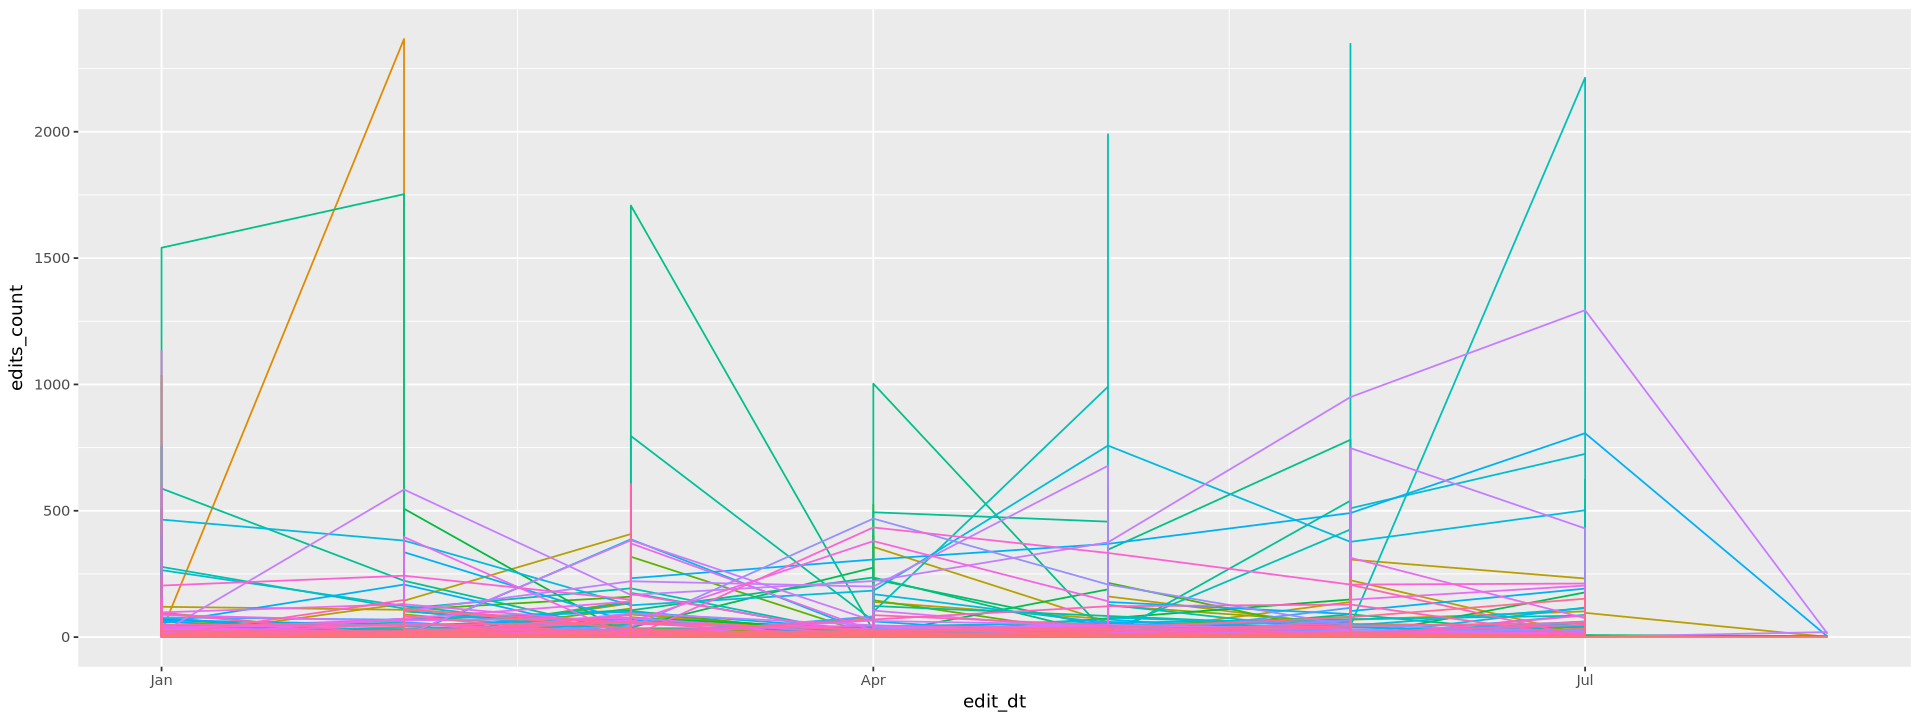

In [133]:
# All project edits, over time (2024 only) - line plot
options(repr.plot.width=16, repr.plot.height=6)
dfe %>%
  filter(year(edit_dt)=="2024") %>%
  ggplot(aes(x=edit_dt, y=edits_count, color=prefix)) +
  geom_line() +
  theme(legend.position="none")

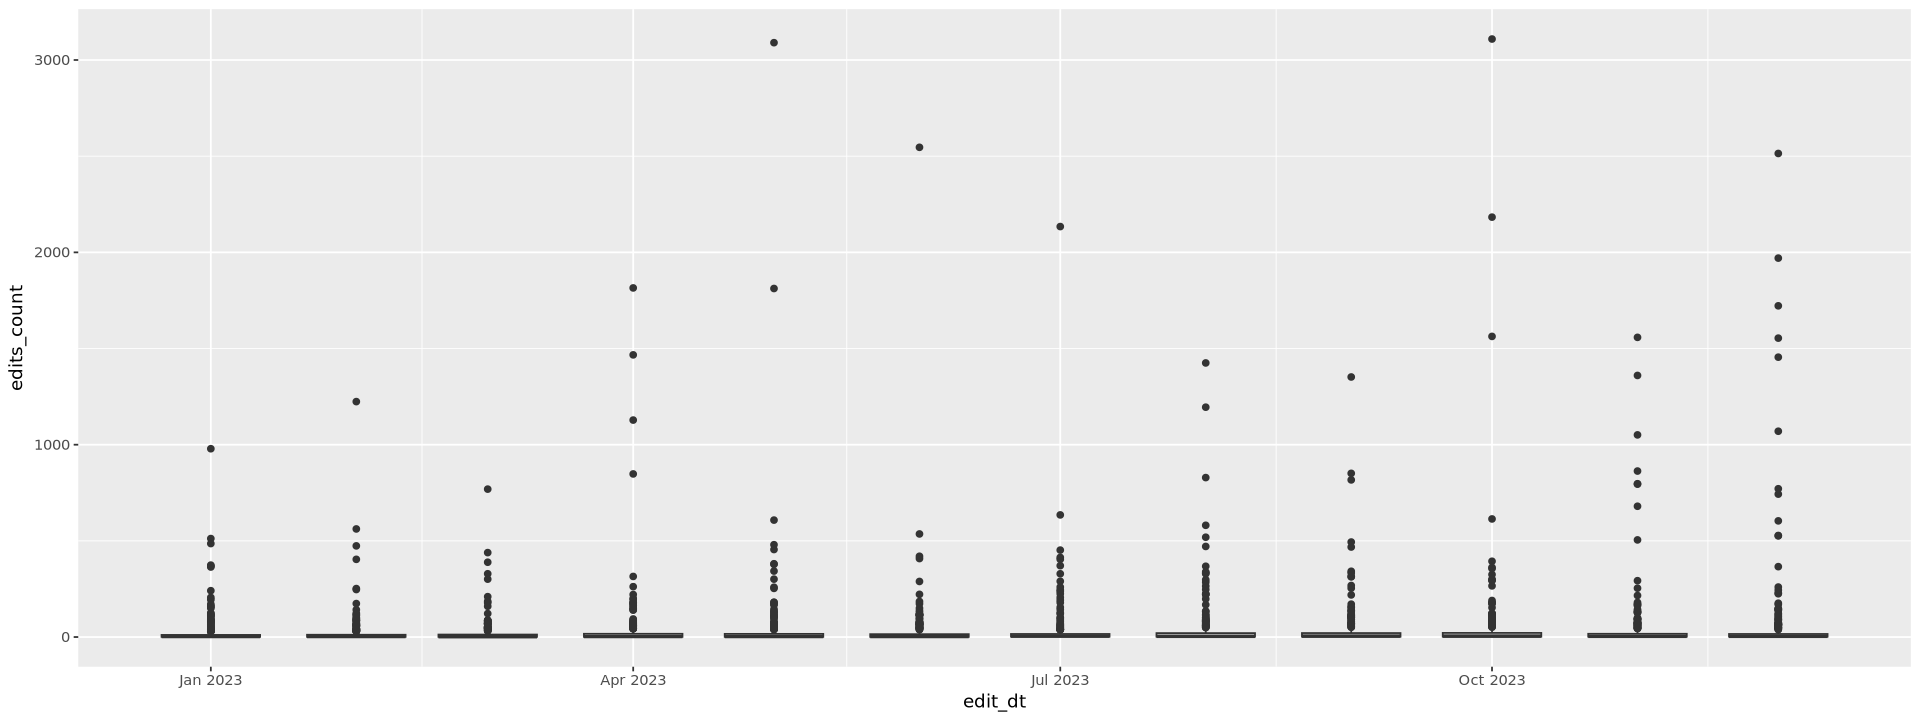

In [134]:
# All project edits, over time (2023 only) - boxplot
options(repr.plot.width=16, repr.plot.height=6)
dfe %>% 
  filter(year(edit_dt)=="2023") %>%
  ggplot(aes(x=edit_dt, y=edits_count, group=month(edit_dt))) +
  geom_boxplot() 

## Look at average monthly edits in 2023

In [135]:
# filter for 2023
dfe_2023 <- dfe %>% 
  filter(year(edit_dt)=="2023") 

# widen df
dfe_2023 <- dfe_2023 %>%
  select(-c(year, month)) %>%
  spread(key="edit_dt", value="edits_count") 

# make date columns numeric
dfe_2023 <- dfe_2023 %>% 
  mutate_if(is.double, as.integer)

# make NAs into 0s in the "2023-.." columns
dfe_2023[, 5:16][is.na(dfe_2023[, 5:16])] <- 0

head(dfe_2023)

prefix page_namespace language_name canonical_status test-host     project  
1 Wb/aa   0             Afar          closed           test (closed) Wikibooks
2 Wb/ab   0             Abkhazian     NA               test          Wikibooks
3 Wb/ab   1             Abkhazian     NA               test          Wikibooks
4 Wb/ab  14             Abkhazian     NA               test          Wikibooks
5 Wb/ace  0             Achinese      NA               test          Wikibooks
6 Wb/ace 10             Achinese      NA               test          Wikibooks
  2023-01-01 2023-02-01 2023-03-01 2023-04-01 2023-05-01 2023-06-01 2023-07-01
1 1          0          0          0          1          0           0        
2 0          2          0          2          0          0           0        
3 0          0          0          0          0          0           0        
4 0          0          0          0          0          1           0        
5 0          0          0          0          0          0          20        
6 0          0          0          0          0          0          15        
  2023-08-01 2023-09-01 2023-10-01 2023-11-01 2023-12-01
1  0         0           0         NA         NA        
2  0         0           3          2         NA        
3  0         0          10         NA         NA        
4  0         0           0         NA         NA        
5  4         0           0         NA         NA        
6 17         0           0         NA         NA

In [138]:
# calculate and round means
dfe_2023 <- dfe_2023 %>% 
    mutate(mean = round(rowMeans(as.matrix(.[grep('2023', names(.))]), na.rm = TRUE), 1))

# calculate and round medians
dfe_2023 <- dfe_2023 %>% 
    mutate(median = round(rowMedians(as.matrix(.[grep('2023', names(.))]), na.rm = TRUE), 1))

# remove monthly columns
dfe_2023 <- dfe_2023 %>%
  select(prefix, mean, median)

# preview
head(dfe_2023 %>% arrange(desc(mean)))
tail(dfe_2023 %>% arrange(desc(mean)))

prefix mean   median
1 Wp/mos 1473.8 1273.5
2 Wp/knc  753.3  618.5
3 Wt/mad  442.2    0.0
4 Wp/kge  323.2   60.5
5 Wp/rki  317.7  108.5
6 Wb/nia  270.3  119.5

prefix mean median
1411 Wy/shi 0.1  0     
1412 Wy/si  0.1  0     
1413 Wy/sk  0.1  0     
1414 Wy/te  0.1  0     
1415 Wy/uz  0.1  0     
1416 Wy/zu  0.1  0

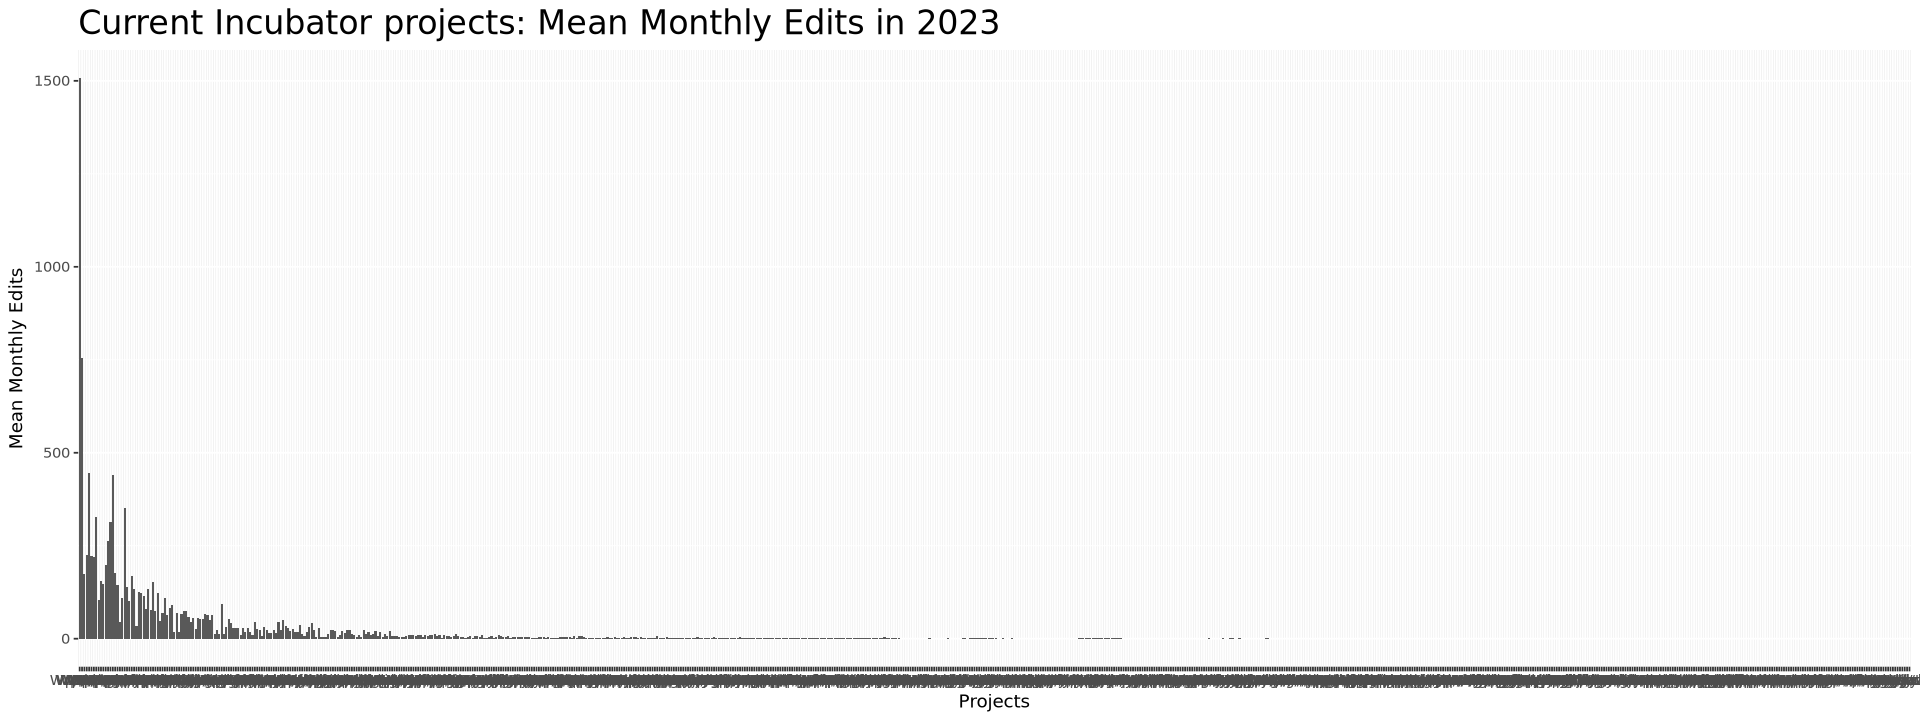

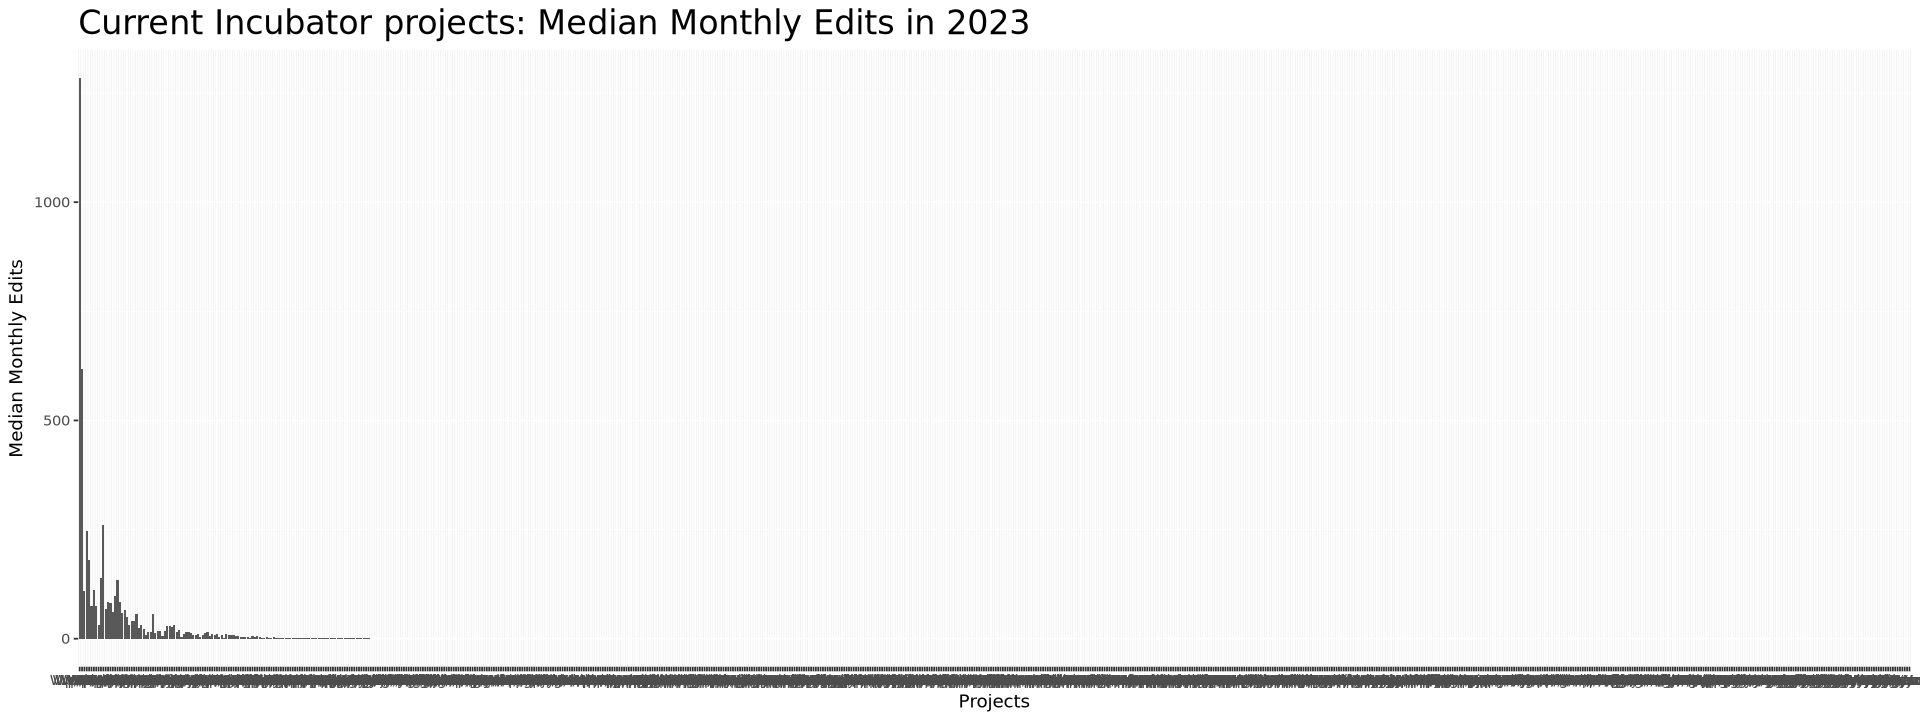

In [139]:
# Plot: Range of means
options(repr.plot.width=16, repr.plot.height=6)
dfe_2023 %>%
 ggplot(aes(x=reorder(prefix,-mean), y=mean)) +
 geom_bar(stat="identity") + xlab("Projects") +
 theme(plot.title=element_text(size=20)) +
 ylab("Mean Monthly Edits") +
 labs(title="Current Incubator projects: Mean Monthly Edits in 2023")

# Plot: Range of medians
options(repr.plot.width=16, repr.plot.height=6)
dfe_2023 %>%
 ggplot(aes(x=reorder(prefix,-median), y=median)) +
 geom_bar(stat="identity") + xlab("Projects") +
 theme(plot.title=element_text(size=20)) +
 ylab("Median Monthly Edits") +
 labs(title="Current Incubator projects: Median Monthly Edits in 2023")

Warning message:
“Removed 385 rows containing missing values or values outside the scale range
(`geom_bar()`).”


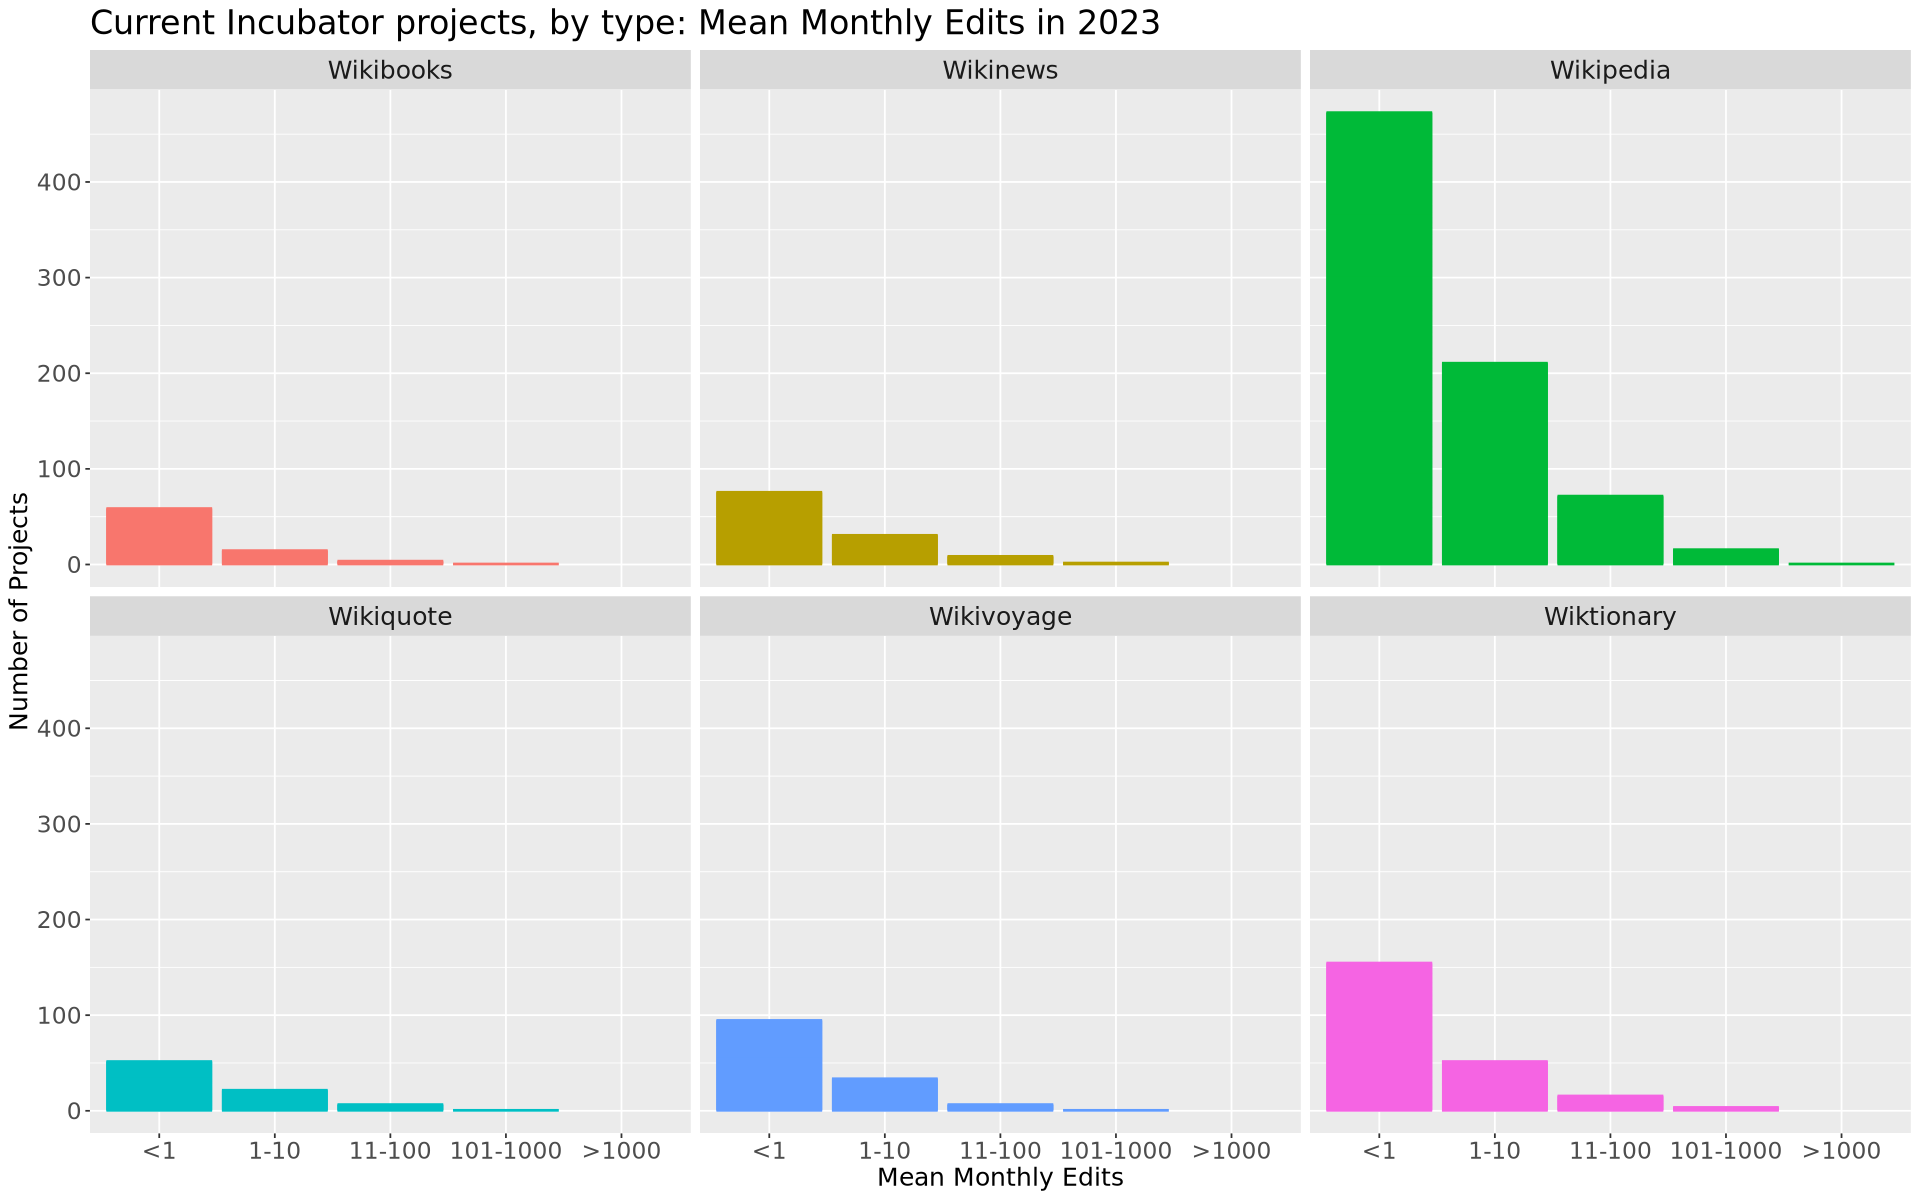

In [140]:
# MEAN BUCKETS
dfe_2023$mean_bucket <- NA
dfe_2023$mean_bucket[dfe_2023$mean<1] <- "<1"
dfe_2023$mean_bucket[dfe_2023$mean>=1 & dfe_2023$mean<11] <- "1-10"
dfe_2023$mean_bucket[dfe_2023$mean>10 & dfe_2023$mean<101] <- "11-100"
dfe_2023$mean_bucket[dfe_2023$mean>100 & dfe_2023$mean<1001] <- "101-1000"
dfe_2023$mean_bucket[dfe_2023$mean>1000] <- ">1000"

#factor
dfe_2023$mean_bucket <-  factor(dfe_2023$mean_bucket, levels = c("<1", "1-10", "11-100", "101-1000", ">1000"))

# dummy count for plotting
dfe_2023$count <- 1

# preview
# head(dfe_2023)

# Plot: Range of mean buckets
options(repr.plot.width=16, repr.plot.height=6)
dfe_2023 %>%
 ggplot(aes(x=reorder(mean_bucket,-count), y=count)) +
 geom_bar(stat="identity") + xlab("Mean Monthly Edits") +
 theme(plot.title=element_text(size=20), 
       axis.text=element_text(size=14),
       axis.title=element_text(size=15)) +
 ylab("Number of Projects") +
 labs(title="Current Incubator projects: Mean Monthly Edits in 2023") +
 ylim(0,525)


# prep for project type
dfe_2023$project_type <- NA
dfe_2023$project_type[grepl("Wp/", dfe_2023$prefix)] <- "Wikipedia"
dfe_2023$project_type[grepl("Wb/", dfe_2023$prefix)] <- "Wikibooks"
dfe_2023$project_type[grepl("Wn/", dfe_2023$prefix)] <- "Wikinews"
dfe_2023$project_type[grepl("Wq/", dfe_2023$prefix)] <- "Wikiquote"
dfe_2023$project_type[grepl("Wt/", dfe_2023$prefix)] <- "Wiktionary"
dfe_2023$project_type[grepl("Wv/", dfe_2023$prefix)] <- "Wikiversity"
dfe_2023$project_type[grepl("Wy/", dfe_2023$prefix)] <- "Wikivoyage"


# Plot: Range of mean buckets, by project type
options(repr.plot.width=16, repr.plot.height=10)
dfe_2023 %>%
 ggplot(aes(x=reorder(mean_bucket,-count), y=count, color=project_type)) +
 geom_bar(stat="identity") + xlab("Mean Monthly Edits") +
 theme(plot.title=element_text(size=20), 
       axis.text=element_text(size=14),
       axis.title=element_text(size=15),
       strip.text=element_text(size=15),
       legend.position="none") +
 ylab("Number of Projects") +
 labs(title="Current Incubator projects, by type: Mean Monthly Edits in 2023") +
 facet_wrap(.~project_type, ncol=3) 

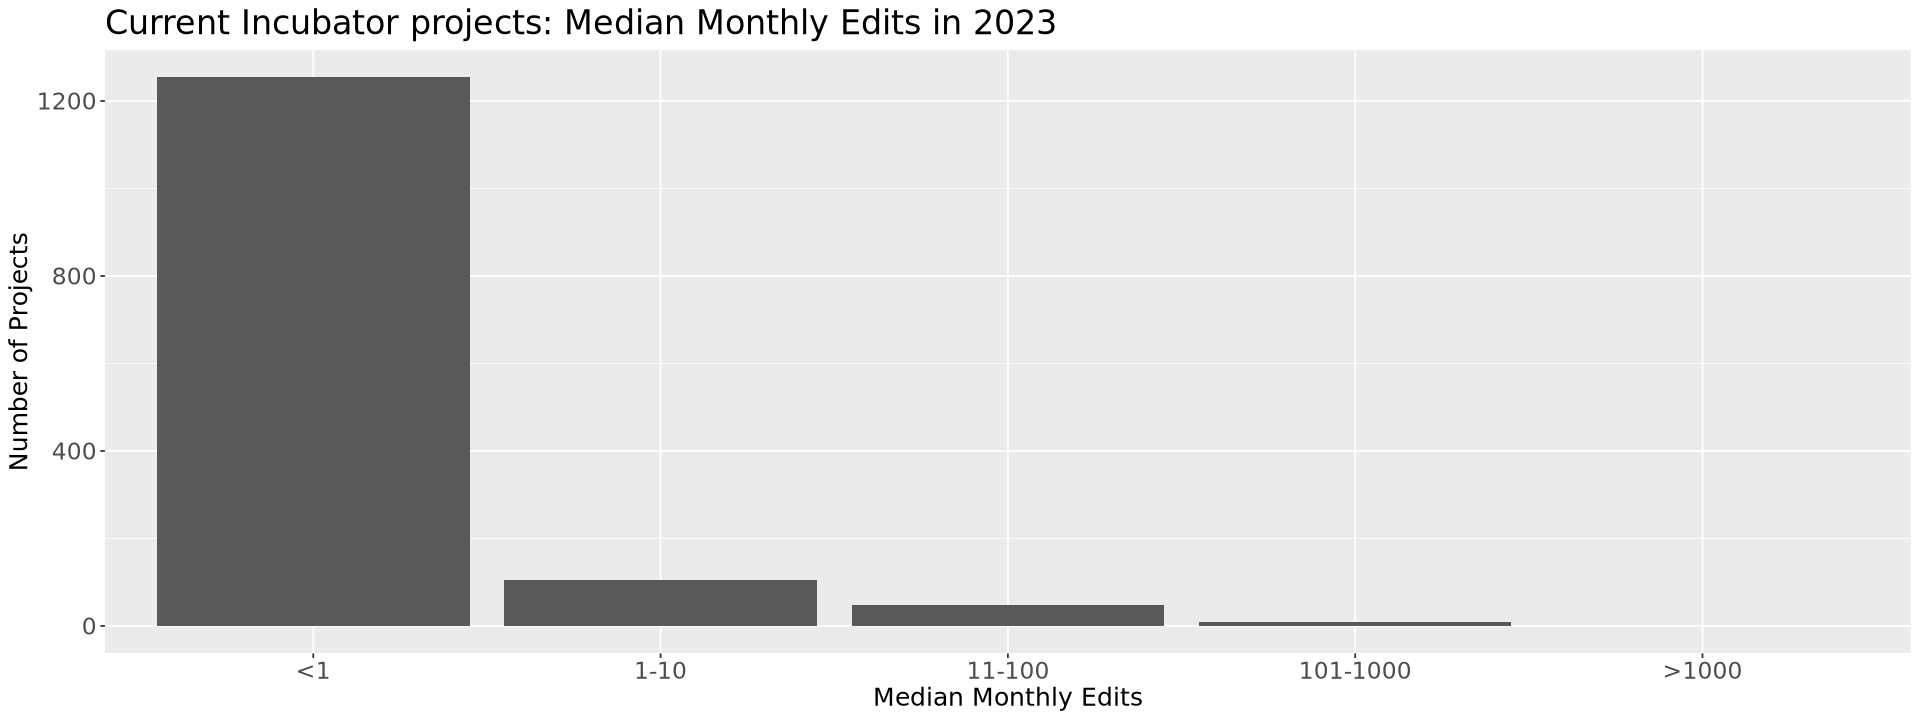

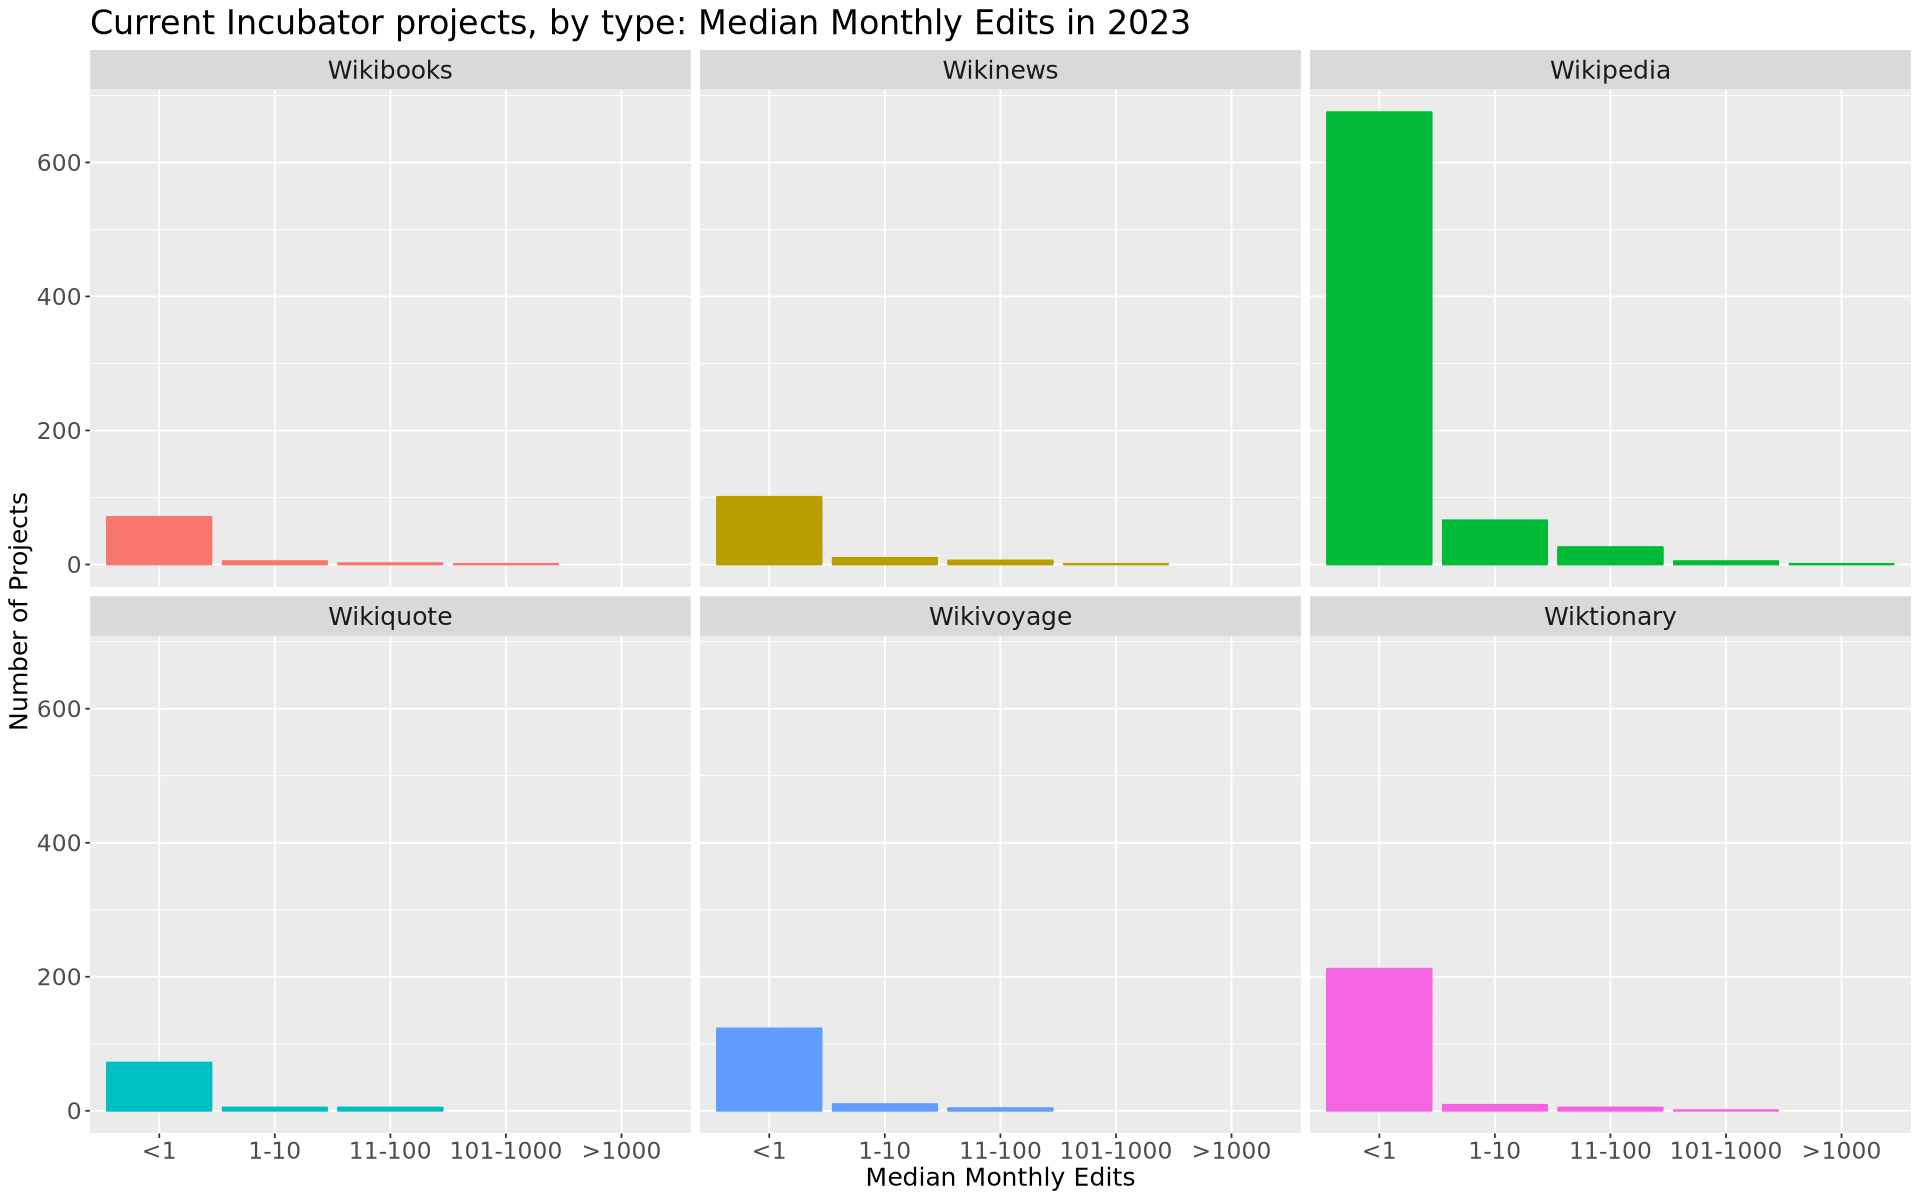

In [141]:
# MEDIAN BUCKETS
dfe_2023$median_bucket <- NA
dfe_2023$median_bucket[dfe_2023$median<1] <- "<1"
dfe_2023$median_bucket[dfe_2023$median>=1 & dfe_2023$median<11] <- "1-10"
dfe_2023$median_bucket[dfe_2023$median>10 & dfe_2023$median<101] <- "11-100"
dfe_2023$median_bucket[dfe_2023$median>100 & dfe_2023$median<1001] <- "101-1000"
dfe_2023$median_bucket[dfe_2023$median>1000] <- ">1000"

#factor
dfe_2023$median_bucket <-  factor(dfe_2023$median_bucket, levels = c("<1", "1-10", "11-100", "101-1000", ">1000"))

# dummy count for plotting
dfe_2023$count <- 1

# preview
# head(dfe_2023)

# Plot: Range of median buckets
options(repr.plot.width=16, repr.plot.height=6)
dfe_2023 %>%
 ggplot(aes(x=reorder(median_bucket,-count), y=count)) +
 geom_bar(stat="identity") + xlab("Median Monthly Edits") +
 theme(plot.title=element_text(size=20), 
       axis.text=element_text(size=14),
       axis.title=element_text(size=15)) +
 ylab("Number of Projects") +
 labs(title="Current Incubator projects: Median Monthly Edits in 2023") 


# prep for project type
dfe_2023$project_type <- NA
dfe_2023$project_type[grepl("Wp/", dfe_2023$prefix)] <- "Wikipedia"
dfe_2023$project_type[grepl("Wb/", dfe_2023$prefix)] <- "Wikibooks"
dfe_2023$project_type[grepl("Wn/", dfe_2023$prefix)] <- "Wikinews"
dfe_2023$project_type[grepl("Wq/", dfe_2023$prefix)] <- "Wikiquote"
dfe_2023$project_type[grepl("Wt/", dfe_2023$prefix)] <- "Wiktionary"
dfe_2023$project_type[grepl("Wv/", dfe_2023$prefix)] <- "Wikiversity"
dfe_2023$project_type[grepl("Wy/", dfe_2023$prefix)] <- "Wikivoyage"


# Plot: Range of median buckets, by project type
options(repr.plot.width=16, repr.plot.height=10)
dfe_2023 %>%
 ggplot(aes(x=reorder(median_bucket,-count), y=count, color=project_type)) +
 geom_bar(stat="identity") + xlab("Median Monthly Edits") +
 theme(plot.title=element_text(size=20), 
       axis.text=element_text(size=14),
       axis.title=element_text(size=15),
       strip.text=element_text(size=15),
       legend.position="none") +
 ylab("Number of Projects") +
 labs(title="Current Incubator projects, by type: Median Monthly Edits in 2023") +
 facet_wrap(.~project_type, ncol=3)

In [142]:
# Show data plotted above as a table (i.e., page number buckets project, but as %s)
dfe_2023$weight=1
as.data.frame(moe_crosstab(df=dfe_2023, x=project_type, y=median_bucket, weight=weight)) %>%
 mutate(pct=paste0(round(pct,1), "%")) %>%
 select(project_type, median_bucket, pct) %>%
 spread(key=median_bucket, value=pct)

project_type <1    1-10 11-100 101-1000 >1000
1 Wikibooks    89.9% 6.3% 2.5%   1.3%     NA   
2 Wikinews     85.6% 8.5% 5.1%   0.8%     NA   
3 Wikipedia    87.3% 8.5% 3.4%   0.6%     0.1% 
4 Wikiquote    87.8% 6.1% 6.1%   NA       NA   
5 Wikivoyage   89.8% 7.3% 2.9%   NA       NA   
6 Wiktionary   93.4% 4%   2.2%   0.4%     NA

prefix mean median mean_bucket count project_type median_bucket weight
1 Wb/aa  0.2  0      <1          1     Wikibooks    <1            1     
2 Wb/ab  0.8  0      <1          1     Wikibooks    <1            1     
3 Wb/ab  1.0  0      1-10        1     Wikibooks    <1            1     
4 Wb/ab  0.1  0      <1          1     Wikibooks    <1            1     
5 Wb/ace 2.4  0      1-10        1     Wikibooks    <1            1     
6 Wb/ace 3.2  0      1-10        1     Wikibooks    <1            1     
  first_edit_year
1 2008           
2 2017           
3 2017           
4 2017           
5 2017           
6 2017

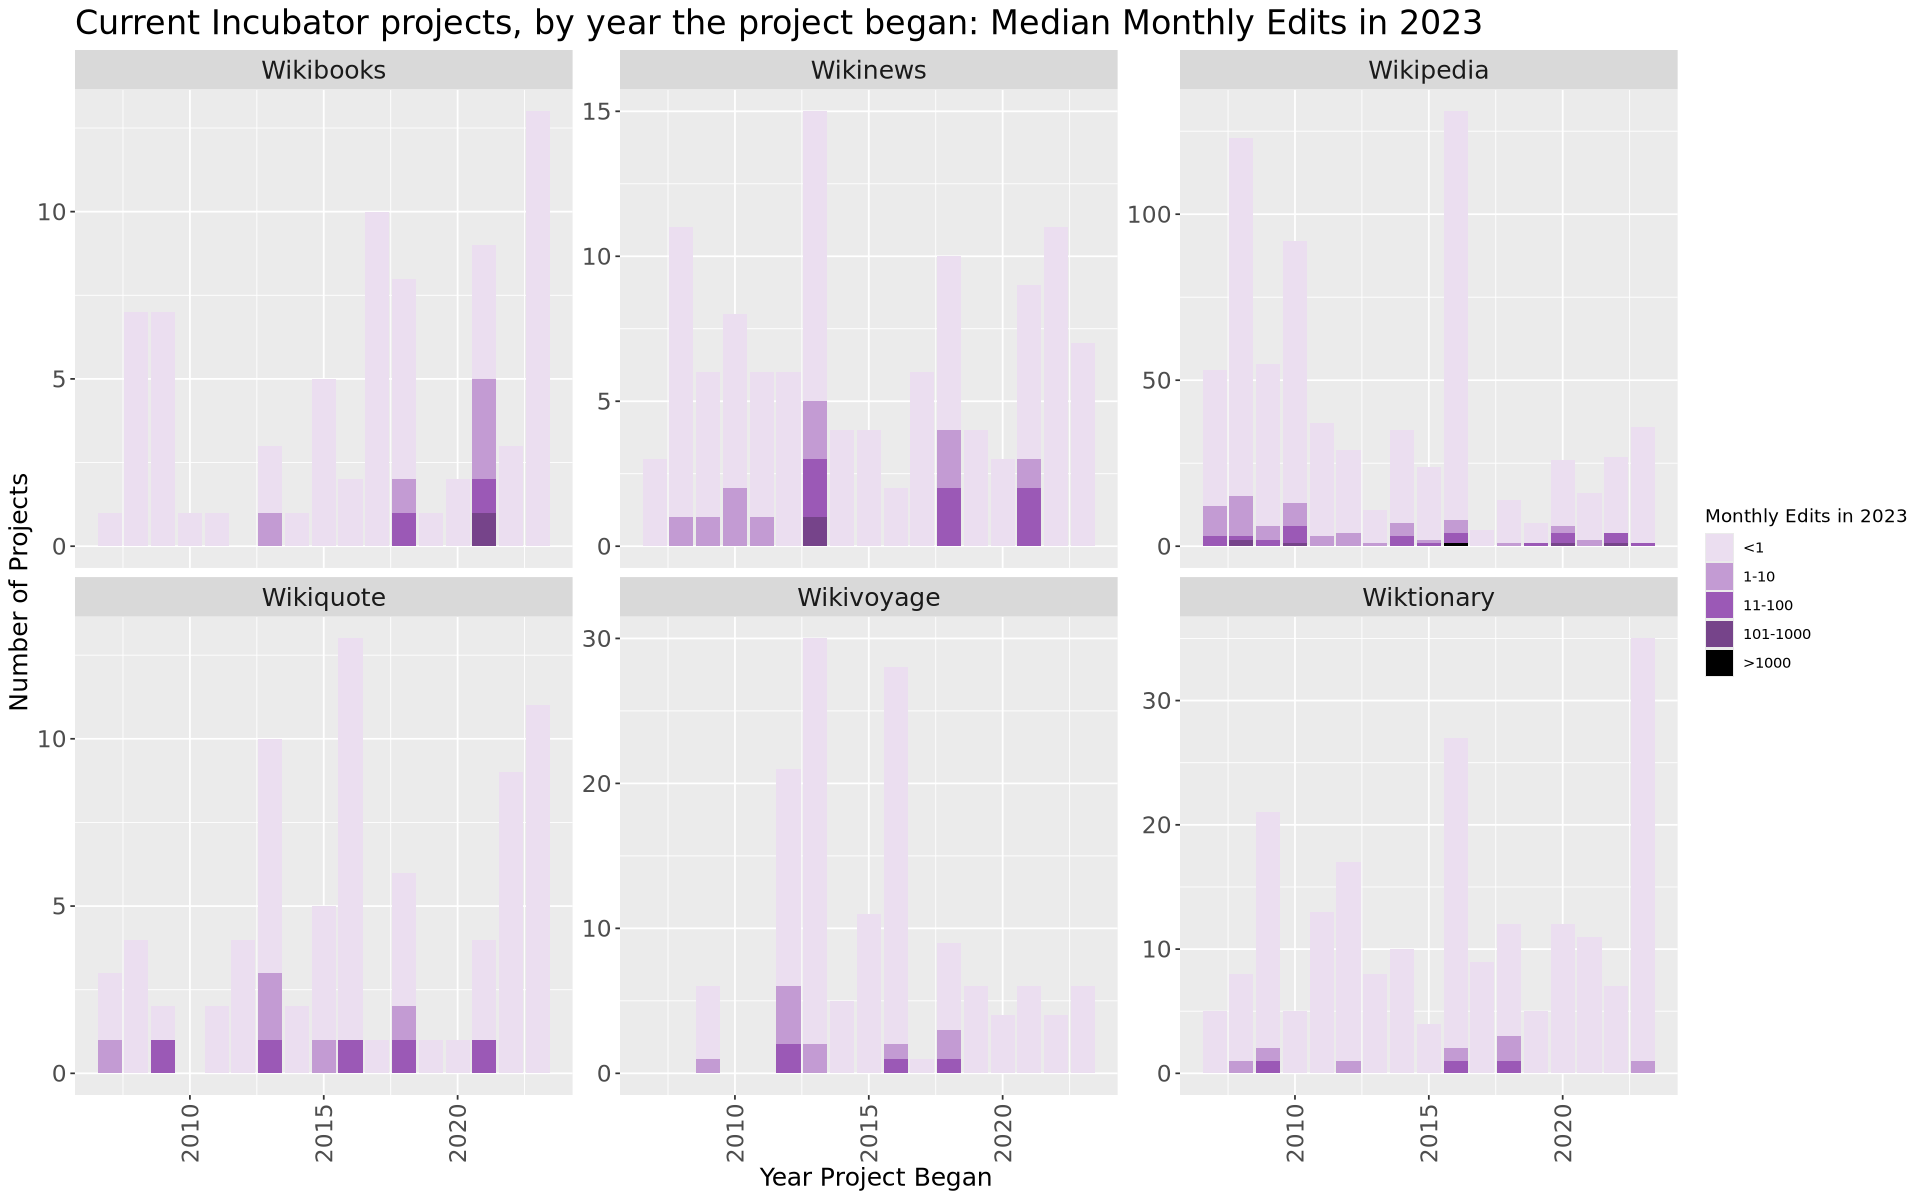

In [143]:
## Show data plotted above but faceted by the year the project started
q2 <- dfe_2023 %>% 
 left_join(., (df %>% select(prefix, first_edit_timestamp)), by="prefix") %>%
 mutate(first_edit_year = lubridate::year(first_edit_timestamp)) %>% 
 select(-first_edit_timestamp) %>%
 mutate(weight=1)

head(q2)

moe_crosstab_3way(df=q2, x=project_type, y=median_bucket, z=first_edit_year, weight=weight) %>%
 mutate(pct_x_n = pct/100*n) %>%
 filter(first_edit_year > 2006) %>% # filter out weird cases
 ggplot(aes(x=first_edit_year, y=pct_x_n, fill=median_bucket)) +
 geom_bar(stat="identity") + xlab("Year Project Began") +
 theme(plot.title=element_text(size=20), 
       axis.text.y=element_text(size=14),
       axis.title=element_text(size=15),
       axis.text.x = element_text(angle = 90, size=14, vjust = 0.5, hjust=1),
       strip.text=element_text(size=15)) +
 ylab("Number of Projects") +
 labs(title="Current Incubator projects, by year the project began: Median Monthly Edits in 2023") +
 facet_wrap(.~project_type, ncol=3, scales="free_y") +
 scale_fill_manual(values = c("#EBDEF0",  "#C39BD3",  "#9B59B6",  "#76448A", "black")) +
 guides(fill=guide_legend(title="Monthly Edits in 2023"))